In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot
import eelbrain
import mne
#import trftools
from pprint import pprint
import numpy as np

import emd  # Ensure you ran: pip install EMD-signal
from scipy.signal import hilbert

import csv
import pandas as pd

/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/eelbrain/mne_fixes/_interpolation.py:13: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types, pick_channels
/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/eelbrain/mne_fixes/_interpolation.py:13: FutureWarning: mne.io.pick.pick_channels is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types, pick_channels


In [3]:
## Natives ##
## Import the raw EEG data of ESLs(Alice)

STIMULI = [str(i) for i in range(1, 13)]
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results") #Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
IMF_DIR = DATA_ROOT/ "TRFs_pridictors/IF_predictors"
F0_DIR = DATA_ROOT/ "TRFs_pridictors/F0_predictors"
IMFsLIST = [path.name for path in IMF_DIR.iterdir() if re.match(r'Alice_IF_IMF_*', path.name)]
EEG_DIR = DATA_ROOT / 'EEG_Natives' / 'Alice_natives_ICAed_fif'
SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'S\d*', path.name[:4])]
# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_Natives'
TRF_DIR.mkdir(exist_ok=True)
print(SUBJECTS)
print(len(SUBJECTS))

wOnset_DIR = DATA_ROOT / 'EEG_Natives' / 'Alice_Natives_wOnset_raw_epochs'
wOnset_DIR .mkdir(exist_ok=True)

['S44_Alice-natives_sfreq-100_raw.fif', 'S20_Alice-natives_sfreq-100_raw.fif', 'S13_Alice-natives_sfreq-100_raw.fif', 'S01_Alice-natives_sfreq-100_raw.fif', 'S16_Alice-natives_sfreq-100_raw.fif', 'S41_Alice-natives_sfreq-100_raw.fif', 'S25_Alice-natives_sfreq-100_raw.fif', 'S37_Alice-natives_sfreq-100_raw.fif', 'S04_Alice-natives_sfreq-100_raw.fif', 'S18_Alice-natives_sfreq-100_raw.fif', 'S39_Alice-natives_sfreq-100_raw.fif', 'S10_Alice-natives_sfreq-100_raw.fif', 'S15_Alice-natives_sfreq-100_raw.fif', 'S26_Alice-natives_sfreq-100_raw.fif', 'S42_Alice-natives_sfreq-100_raw.fif', 'S34_Alice-natives_sfreq-100_raw.fif', 'S38_Alice-natives_sfreq-100_raw.fif', 'S19_Alice-natives_sfreq-100_raw.fif', 'S06_Alice-natives_sfreq-100_raw.fif', 'S35_Alice-natives_sfreq-100_raw.fif', 'S14_Alice-natives_sfreq-100_raw.fif', 'S03_Alice-natives_sfreq-100_raw.fif', 'S11_Alice-natives_sfreq-100_raw.fif', 'S22_Alice-natives_sfreq-100_raw.fif', 'S05_Alice-natives_sfreq-100_raw.fif', 'S36_Alice-natives_sfreq

In [4]:
# Import the csv data
csv_data = DATA_ROOT / "Alice(EEG_mat_and stimuli)" / "AliceChapterOne-EEG.csv"  # self-made LMM data form


word_onset_LIST = []
with open(csv_data, "r", encoding="UTF-8") as f:
    fileDF = pd.read_csv(f, sep=",")
    #print(fileDF.columns)
    # word_onset = fileDF["onset"]
    # print(word_onset, type(word_onset))

    word_onset_essentials_DF = fileDF.iloc[:,[0, 1, 2] ]     # first column
    #print(word_onset_essentials_DF["onset"], word_onset_essentials_DF["onset"])
    #print()

    for i in range(1, 13):
        print(i)
        #w_S = word_onset_essentials_DF.loc[:, [i]["Word"]]
        #wOnset_F = word_onset_essentials_DF.loc[:, 2]
        #print(w_S)

        wOnset_DF = word_onset_essentials_DF.loc[word_onset_essentials_DF["Segment"] == 2, :]
        print(wOnset_DF, type(wOnset_DF))
        print(wOnset_DF["onset"])
        """
        if 
        w_S = word_onset_essentials_DF.iloc[i, 0]
        wOnset_F = word_onset_essentials_DF.iloc[i, 2]
        print(w_S, wOnset_F)
        """

1
         Word  Segment      onset
174       but        2   0.479840
175      when        2   0.592424
176       the        2   0.810806
177    Rabbit        2   0.912952
178  actually        2   1.415810
..        ...      ...        ...
346       was        2  58.681660
347     going        2  58.861252
348        to        2  59.148599
349    happen        2  59.251158
350      next        2  59.687374

[177 rows x 3 columns] <class 'pandas.core.frame.DataFrame'>
174     0.479840
175     0.592424
176     0.810806
177     0.912952
178     1.415810
         ...    
346    58.681660
347    58.861252
348    59.148599
349    59.251158
350    59.687374
Name: onset, Length: 177, dtype: float64
2
         Word  Segment      onset
174       but        2   0.479840
175      when        2   0.592424
176       the        2   0.810806
177    Rabbit        2   0.912952
178  actually        2   1.415810
..        ...      ...        ...
346       was        2  58.681660
347     going        2  58

In [208]:
for subject in SUBJECTS:#[0:3]:
    #print("subject_num=", subject)
    
    # 1. Load Raw as an Eelbrain-compatible object
    raw = mne.io.read_raw_fif(EEG_DIR / f'{subject}', preload=True)
    raw_sfreq = raw.info['sfreq']
    
    # 2. Get the events for the 12 tapes
    events_DICT = eelbrain.load.mne.events(raw)
    #print(events_DICT["event"])

    """
    if len(events_DICT["event"])==12:
        pass
    else:
        print(subject[:3], "tape_length", )"""

In [203]:
for i, stimulus_idx in enumerate(trial_indexes[1:]):
    print("i = ", i)
    print("stimulus_idx", stimulus_idx)

i =  0
stimulus_idx 1
i =  1
stimulus_idx 2
i =  2
stimulus_idx 3
i =  3
stimulus_idx 4
i =  4
stimulus_idx 5
i =  5
stimulus_idx 6
i =  6
stimulus_idx 7
i =  7
stimulus_idx 8
i =  8
stimulus_idx 9
i =  9
stimulus_idx 10
i =  10
stimulus_idx 11


In [209]:
## (Use this!!!)Trying the old way (Sub order 1st then tape 2nd)##

# epochs parameters
# Define your epoch window
# We use a 1.5s window (including buffers for HHSA)
tmin, tmax = -0.3, 1.2 

for subject in SUBJECTS:#[0:3]:
    print("subject_num=", subject)
    
    # 1. Load Raw as an Eelbrain-compatible object
    raw = mne.io.read_raw_fif(EEG_DIR / f'{subject}', preload=True)
    raw_sfreq = raw.info['sfreq']
    raw_ch_names = raw
    
    # 2. Get the events for the 12 tapes
    events_DICT = eelbrain.load.mne.events(raw)
    trial_indexes = [STIMULI.index(stimulus) for stimulus in events['event']]

    if len(events_DICT['event'])==12:
        # Get the actual word onset based on EEG triggers datapoints
        all_tapes_epochs_LIST = []
        for i, stimulus_idx in enumerate(trial_indexes):
            print("tape_num=", stimulus_idx+1)
            
            # Find the word onset time based on the segment sequence    
            wOnset_perTape_DF = word_onset_essentials_DF.loc[word_onset_essentials_DF["Segment"] == stimulus_idx+1, :] #.to_numpy()
            print("wOnset_perTape_DF=", wOnset_perTape_DF)
            #wOnset_time_ndarray = wOnset_perTape_DF["onset"].to_numpy() #*raw_sfreq
            wOnset_datapoints_ndarray = wOnset_perTape_DF["onset"].to_numpy()*raw_sfreq
            print("wOnset_datapoints_ndarray=", wOnset_datapoints_ndarray[0:15], type(wOnset_datapoints_ndarray))
    
            # Get the tape start time
            tape_start_datapoints_npINT64 = events_DICT[i]['i_start']
            #tape_start_time_npFLOAT64 = tape_start_datapoints_npINT64 / raw_sfreq
            print("tape_start_datapoints_npINT64=", tape_start_datapoints_npINT64)
            #print("tape_start_time_npFLOAT64=", tape_start_time_npFLOAT64, type(tape_start_time_npFLOAT64))
    
            # Get the actual word onset time by the triggers
            #absolute_onsets_time_ndarray = tape_start_time_npFLOAT64 + wOnset_time_ndarray
            #print("absolute_onsets_time_ndarray=", absolute_onsets_time_ndarray[0:15])
            abs_wOnsets_dta_ndarray = tape_start_datapoints_npINT64 + wOnset_datapoints_ndarray
            print("abs_wOnsets_dta_ndarray=", abs_wOnsets_dta_ndarray[0:15])
            
            # To exclude the decimal but leave the integer along, and turn FLOAT into INT
            abs_wOnsets_dta_ndarray = np.trunc(abs_wOnsets_dta_ndarray).astype(int)
            print("rounded_abs_wOnsets_dta_ndarray=", abs_wOnsets_dta_ndarray[0:15])
            
            # Make epochs
            # Create the empty (N, 3) event matrix based on wOnset per tape
            wOnset_events = len(abs_wOnsets_dta_ndarray)
            wOnset_perTape_events = np.zeros((wOnset_events, 3), dtype=int)
            # Fill the columns
            wOnset_perTape_events[:, 0] = abs_wOnsets_dta_ndarray  # Column 0: The sample indices
            wOnset_perTape_events[:, 2] = stimulus_idx+1           # Column 2: The event ID (e.g., 1)
            print(wOnset_perTape_events)
            
            #word_perTape_epochs = mne.epochs(raw, tmin=tmin, tmax=tmax, baseline=None, events=wOnset_perTape_events)
            tape_perTape_epochs = mne.Epochs(raw, events=wOnset_perTape_events, event_id=stimulus_idx+1, tmin=tmin, tmax=tmax, baseline=None, preload=True)
            print(tape_perTape_epochs)
            all_tapes_epochs_LIST.append(tape_perTape_epochs)
            wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
        wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)
        print("subject_num=", subject[:4], "wOnset epoch saved.")
    
    else:  # For those who only start on the 2nd tape
        # Get the actual word onset based on EEG triggers datapoints
        all_tapes_epochs_LIST = []
        for i, stimulus_idx in enumerate(trial_indexes[1:]):
            print("tape_num=", stimulus_idx+1)
            
            # Find the word onset time based on the segment sequence    
            wOnset_perTape_DF = word_onset_essentials_DF.loc[word_onset_essentials_DF["Segment"] == stimulus_idx+1, :] #.to_numpy()
            print("wOnset_perTape_DF=", wOnset_perTape_DF)
            #wOnset_time_ndarray = wOnset_perTape_DF["onset"].to_numpy() #*raw_sfreq
            wOnset_datapoints_ndarray = wOnset_perTape_DF["onset"].to_numpy()*raw_sfreq
            print("wOnset_datapoints_ndarray=", wOnset_datapoints_ndarray[0:15], type(wOnset_datapoints_ndarray))
    
            # Get the tape start time
            tape_start_datapoints_npINT64 = events_DICT[i]['i_start']
            #tape_start_time_npFLOAT64 = tape_start_datapoints_npINT64 / raw_sfreq
            print("tape_start_datapoints_npINT64=", tape_start_datapoints_npINT64)
            #print("tape_start_time_npFLOAT64=", tape_start_time_npFLOAT64, type(tape_start_time_npFLOAT64))
    
            # Get the actual word onset time by the triggers
            #absolute_onsets_time_ndarray = tape_start_time_npFLOAT64 + wOnset_time_ndarray
            #print("absolute_onsets_time_ndarray=", absolute_onsets_time_ndarray[0:15])
            abs_wOnsets_dta_ndarray = tape_start_datapoints_npINT64 + wOnset_datapoints_ndarray
            print("abs_wOnsets_dta_ndarray=", abs_wOnsets_dta_ndarray[0:15])
            
            # To exclude the decimal but leave the integer along, and turn FLOAT into INT
            abs_wOnsets_dta_ndarray = np.trunc(abs_wOnsets_dta_ndarray).astype(int)
            print("rounded_abs_wOnsets_dta_ndarray=", abs_wOnsets_dta_ndarray[0:15])
            
            # Make epochs
            # Create the empty (N, 3) event matrix based on wOnset per tape
            wOnset_events = len(abs_wOnsets_dta_ndarray)
            wOnset_perTape_events = np.zeros((wOnset_events, 3), dtype=int)
            # Fill the columns
            wOnset_perTape_events[:, 0] = abs_wOnsets_dta_ndarray  # Column 0: The sample indices
            wOnset_perTape_events[:, 2] = stimulus_idx+1           # Column 2: The event ID (e.g., 1)
            print(wOnset_perTape_events)
            
            #word_perTape_epochs = mne.epochs(raw, tmin=tmin, tmax=tmax, baseline=None, events=wOnset_perTape_events)
            tape_perTape_epochs = mne.Epochs(raw, events=wOnset_perTape_events, event_id=stimulus_idx+1, tmin=tmin, tmax=tmax, baseline=None, preload=True)
            print(tape_perTape_epochs)
            all_tapes_epochs_LIST.append(tape_perTape_epochs)
            wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
        wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_11Tapes_raw.fif' %subject[:3]), overwrite=True)
        print("subject_num=", subject[:4], "wOnset epoch saved.")
    

"""
    # 5. Combine all words from all tapes into one Dataset
    # This 'ds' will have a column for 'EEG' and can have a column for 'Subject'
    ds_all_words = eelbrain.combine(all_tapes_epochs)
    
    # Now you can access the data for HHSA:
    # eeg_data = ds_all_words['eeg'].get_data()
    """

subject_num= S44_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 172
abs_wOnsets_dta_ndarray= [176.6    228.2721 250.4543 297.6929 307.2925 333.6327 403.0749 451.9918
 465.8712 502.449  520.4082 537.4596 582.6667 599.4286 611.8799]
rounded_abs_wOnsets_dta_ndarray= [176 228 250 297 307 333 403 451 465 502 520 537 582 599

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

wOnset_perTape_DF=       Word  Segment      onset
351  First        3   0.478723
352    she        3   0.986270
353  tried        3   1.201781
354     to        3   1.501100
355   look        3   1.604643
..     ...      ...        ...
530   this        3  61.269264
531   time        3  61.591394
532    she        3  62.071440
533   said        3  62.263005
534  aloud        3  62.538379

[184 rows x 3 columns]
wOnset_datapoints_ndarray= [ 47.8723402  98.6269787 120.1780787 150.1099787 160.4642787 183.6337787
 218.3548787 231.5249787 260.2596787 284.2052787 296.1780787 314.3827787
 333.2936787 371.6065787 450.6269787] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 12023
abs_wOnsets_dta_ndarray= [12070.8723402 12121.6269787 12143.1780787 12173.1099787 12183.4642787
 12206.6337787 12241.3548787 12254.5249787 12283.2596787 12307.2052787
 12319.1780787 12337.3827787 12356.2936787 12394.6065787 12473.6269787]
rounded_abs_wOnsets_dta_ndarray= [12070 12121 12143 12173 12183 12206 1224

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 6
wOnset_perTape_DF=        Word  Segment      onset
942     Now        6   0.323245
943   Dinah        6   0.568709
944    tell        6   1.039809
945      me        6   1.422938
946     the        6   1.590557
...     ...      ...        ...
1134   ever        6  61.825659
1135     to        6  62.101034
1136    get        6  62.268653
1137    out        6  62.436272
1138  again        6  62.663755

[197 rows x 3 columns]
wOnset_datapoints_ndarray= [ 32.3245298  56.8708743 103.9808743 142.2937743 159.0556743 173.0401743
 238.0761743 260.0501743 284.7699743 320.6883743 337.9041743 353.4880743
 473.9400743 496.7131743 597.2597743] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 31990
abs_wOnsets_dta_ndarray= [32022.3245298 32046.8708743 32093.9808743 32132.2937743 32149.0556743
 32163.0401743 32228.0761743 32250.0501743 32274.7699743 32310.6883743
 32327.9041743 32343.4880743 32463.9400743 32486.7131743 32587.2597743]
rounded_abs_wOnsets_dta_ndarray= [32022 32046 3209

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 56136
abs_wOnsets_dta_ndarray= [56241.1980798 56252.0767    56266.8375    56350.647     56414.7119
 56442.9088    56503.0205    56517.0893    56547.0007    56555.3817
 56596.2269    56614.0483    56626.7454    56636.4853    56781.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 67891
abs_wOnsets_dta_ndarray= [67913.9476225 67941.4358225 67956.8032225 67988.4924225 68017.6236225
 68035.1863225 68042.5146225 68071.1046225 68113.0094225 68159.7033225
 68170.4788225 68183.6489225 68220.3501225 68247.1046225 68255.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S44_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S44_ wOnset epoch saved.
subject_num= S20_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 413
abs_wOnsets_dta_ndarray= [417.6    469.2721 491.4543 538.6929 548.2925 574.6327 644.0749 692.9918
 706.8712 743.449  761.4082 778.4596 823.6667 840.4286 852.8799]
rounded_abs_wOnsets_dta_ndarray= [417 469 491 538 5

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25605
abs_wOnsets_dta_ndarray= [25661.1145631 25673.9847173 25698.6113173 25716.5705173 25766.8562173
 25790.8018173 25815.7547173 25827.0976173 25836.2984173 2585

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38623
abs_wOnsets_dta_ndarray= [38681.6736359 38740.9532195 38764.8988195 38792.4362195 38828.1148195
 38853.4974195 38897.7968195 38922.9396195 38960.0553195 39048.6539195
 39069.0076195 39094.1505195 39102.5315195 39150.4226195 39273.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50655
abs_wOnsets_dta_ndarray= [50698.2017422 50759.6814784 50774.8493784 50794.4025784 50830.3209784
 50868.3840784 50890.1848784 50925.9578784 50933.9662784 50966.8107784
 50999.1372784 51008.1518784 51017.0964784 51053.0148784 51102.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62514
abs_wOnsets_dta_ndarray= [62541.448538  62562.9783265 62584.1863265 62620.4477265 62641.9987265
 62675.5225265 62727.0055265 62750.9511265 62759.3320265 62871.8762265
 62883.5823265 62900.6109265 62934.1347265 62947.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S20_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif'

subject_num= S20_ wOnset epoch saved.
subject_num= S13_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 853
abs_wOnsets_dta_ndarray= [ 857.6     909.2721  931.4543  978.6929  988.2925 1014.6327 1084.0749
 1132.9918 1146.8712 1183.449  1201.4082 1218.4596 1263.6667 1280.4286
 1292.8799]
rounded_abs_wOnsets_dta_ndarray= [ 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 26042
abs_wOnsets_dta_ndarray= [26098.1145631 26110.9847173 26135.6113173 26153.5705173 26203.8562173
 26227.8018173 26252.7547173 26264.0976173 26273.2984173 2629

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 39059
abs_wOnsets_dta_ndarray= [39117.6736359 39176.9532195 39200.8988195 39228.4362195 39264.1148195
 39289.4974195 39333.7968195 39358.9396195 39396.0553195 39484.6539195
 39505.0076195 39530.1505195 39538.5315195 39586.4226195 39709.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 51093
abs_wOnsets_dta_ndarray= [51136.2017422 51197.6814784 51212.8493784 51232.4025784 51268.3209784
 51306.3840784 51328.1848784 51363.9578784 51371.9662784 51404.8107784
 51437.1372784 51446.1518784 51455.0964784 51491.0148784 51540.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62952
abs_wOnsets_dta_ndarray= [62979.448538  63000.9783265 63022.1863265 63058.4477265 63079.9987265
 63113.5225265 63165.0055265 63188.9511265 63197.3320265 63309.8762265
 63321.5823265 63338.6109265 63372.1347265 63385.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  137 events (all good), -0.3 – 1.2 s, baseline off, ~9.4 MB, data loaded,
 '12': 137>


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S13_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S13_ wOnset epoch saved.
subject_num= S01_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 373
abs_wOnsets_dta_ndarray= [377.6    429.2721 451.4543 498.6929 508.2925 534.6327 604.0749 652.9918
 666.8712 703.449  721.4082 738.4596 783.6667 800.4286 812.8799]
rounded_abs_wOnsets_dta_ndarray= [377 429 451 498 5

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 4
wOnset_perTape_DF=           Word  Segment      onset
535       must        4   0.398386
536         be        4   0.689428
537    getting        4   0.840938
538  somewhere        4   1.126350
539       near        4   1.542892
..         ...      ...        ...
744      think        4  68.262788
745        you        4  68.437370
746      could        4  68.593016
747     manage        4  68.760635
748         it        4  69.129919

[214 rows x 3 columns]
wOnset_datapoints_ndarray= [ 39.8385787  68.9427631  84.0937631 112.6349631 154.2891631 177.2879631
 184.4716631 225.1791631 234.7573631 248.5197631 312.5805631 335.3288631
 347.3015631 380.8254631 399.0834631] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 18555
abs_wOnsets_dta_ndarray= [18594.8385787 18623.9427631 18639.0937631 18667.6349631 18709.2891631
 18732.2879631 18739.4716631 18780.1791631 18789.7573631 18803.5197631
 18867.5805631 18890.3288631 18902.3015631 18935.8254631 18954.0834631]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  197 events (all good), -0.3 – 1.2 s, baseline off, ~13.5 MB, data loaded,
 '6': 197>
tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38575
abs_wOnsets_dta_ndarray= [38633.6736359 38692.9532195 38716.8988195 38744.4362195 38780.1148195
 38805.4974195 38849.7968195 38874.9396195 38912.0553195 3900

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50608
abs_wOnsets_dta_ndarray= [50651.2017422 50712.6814784 50727.8493784 50747.4025784 50783.3209784
 50821.3840784 50843.1848784 50878.9578784 50886.9662784 5091

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 56335
abs_wOnsets_dta_ndarray= [56440.1980798 56451.0767    56465.8375    56549.647     56613.7119
 56641.9088    56702.0205    56716.0893    56746.0007    56754.3817
 56795.2269    56813.0483    56825.7454    56835.4853    56980.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 68088
abs_wOnsets_dta_ndarray= [68110.9476225 68138.4358225 68153.8032225 68185.4924225 68214.6236225
 68232.1863225 68239.5146225 68268.1046225 68310.0094225 68356.7033225
 68367.4788225 68380.6489225 68417.3501225 68444.1046225 68452.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S01_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S01_ wOnset epoch saved.
subject_num= S16_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 567
abs_wOnsets_dta_ndarray= [ 571.6     623.2721  645.4543  692.6929  702.2925  728.6327  798.0749
  846.9918  860.8712  897.449   915.4082  932.4596  977.6667  994.4286
 1006.8799]
rounded_abs_wOnsets_dta_ndarray= [ 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25754
abs_wOnsets_dta_ndarray= [25810.1145631 25822.9847173 25847.6113173 25865.5705173 25915.8562173
 25939.8018173 25964.7547173 25976.0976173 25985.2984173 26006.8494173
 26018.8222173 26038.7481173 26164.8902173 26206.7950173 26220.6011173]
rounded_abs_wOnsets_dta_nd

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  197 events (all good), -0.3 – 1.2 s, baseline off, ~13.5 MB, data loaded,
 '6': 197>
tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38769
abs_wOnsets_dta_ndarray= [38827.6736359 38886.9532195 38910.8988195 38938.4362195 38974.1148195
 38999.4974195 39043.7968195 39068.9396195 39106.0553195 3919

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50802
abs_wOnsets_dta_ndarray= [50845.2017422 50906.6814784 50921.8493784 50941.4025784 50977.3209784
 51015.3840784 51037.1848784 51072.9578784 51080.9662784 5111

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 56529
abs_wOnsets_dta_ndarray= [56634.1980798 56645.0767    56659.8375    56743.647     56807.7119
 56835.9088    56896.0205    56910.0893    56940.0007    56948.3817
 56989.2269    57007.0483    57019.7454    57029.4853    57174.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 68283
abs_wOnsets_dta_ndarray= [68305.9476225 68333.4358225 68348.8032225 68380.4924225 68409.6236225
 68427.1863225 68434.5146225 68463.1046225 68505.0094225 68551.7033225
 68562.4788225 68575.6489225 68612.3501225 68639.1046225 68647.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S16_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S16_ wOnset epoch saved.
subject_num= S41_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 124
abs_wOnsets_dta_ndarray= [128.6    180.2721 202.4543 249.6929 259.2925 285.6327 355.0749 403.9918
 417.8712 454.449  472.4082 489.4596 534.6667 551.4286 563.8799]
rounded_abs_wOnsets_dta_ndarray= [128 180 202 249 2

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25311
abs_wOnsets_dta_ndarray= [25367.1145631 25379.9847173 25404.6113173 25422.5705173 25472.8562173
 25496.8018173 25521.7547173 25533.0976173 25542.2984173 2556

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38326
abs_wOnsets_dta_ndarray= [38384.6736359 38443.9532195 38467.8988195 38495.4362195 38531.1148195
 38556.4974195 38600.7968195 38625.9396195 38663.0553195 38751.6539195
 38772.0076195 38797.1505195 38805.5315195 38853.4226195 38976.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50360
abs_wOnsets_dta_ndarray= [50403.2017422 50464.6814784 50479.8493784 50499.4025784 50535.3209784
 50573.3840784 50595.1848784 50630.9578784 50638.9662784 5067

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 56088
abs_wOnsets_dta_ndarray= [56193.1980798 56204.0767    56218.8375    56302.647     56366.7119
 56394.9088    56455.0205    56469.0893    56499.0007    56507.3817
 56548.2269    56566.0483    56578.7454    56588.4853    56733.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 67842
abs_wOnsets_dta_ndarray= [67864.9476225 67892.4358225 67907.8032225 67939.4924225 67968.6236225
 67986.1863225 67993.5146225 68022.1046225 68064.0094225 68110.7033225
 68121.4788225 68134.6489225 68171.3501225 68198.1046225 68206.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S41_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S41_ wOnset epoch saved.
subject_num= S25_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 205
abs_wOnsets_dta_ndarray= [209.6    261.2721 283.4543 330.6929 340.2925 366.6327 436.0749 484.9918
 498.8712 535.449  553.4082 570.4596 615.6667 632.4286 644.8799]
rounded_abs_wOnsets_dta_ndarray= [209 261 283 330 3

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25392
abs_wOnsets_dta_ndarray= [25448.1145631 25460.9847173 25485.6113173 25503.5705173 25553.8562173
 25577.8018173 25602.7547173 25614.0976173 25623.2984173 2564

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38407
abs_wOnsets_dta_ndarray= [38465.6736359 38524.9532195 38548.8988195 38576.4362195 38612.1148195
 38637.4974195 38681.7968195 38706.9396195 38744.0553195 38832.6539195
 38853.0076195 38878.1505195 38886.5315195 38934.4226195 39057.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50441
abs_wOnsets_dta_ndarray= [50484.2017422 50545.6814784 50560.8493784 50580.4025784 50616.3209784
 50654.3840784 50676.1848784 50711.9578784 50719.9662784 50752.8107784
 50785.1372784 50794.1518784 50803.0964784 50839.0148784 50888.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62301
abs_wOnsets_dta_ndarray= [62328.448538  62349.9783265 62371.1863265 62407.4477265 62428.9987265
 62462.5225265 62514.0055265 62537.9511265 62546.3320265 62658.8762265
 62670.5823265 62687.6109265 62721.1347265 62734.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S25_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S25_ wOnset epoch saved.
subject_num= S37_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 23
abs_wOnsets_dta_ndarray= [ 27.6     79.2721 101.4543 148.6929 158.2925 184.6327 254.0749 302.9918
 316.8712 353.449  371.4082 388.4596 433.6667 450.4286 462.8799]
rounded_abs_wOnsets_dta_ndarray= [ 27  79 101 148 15

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25210
abs_wOnsets_dta_ndarray= [25266.1145631 25278.9847173 25303.6113173 25321.5705173 25371.8562173
 25395.8018173 25420.7547173 25432.0976173 25441.2984173 2546

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38226
abs_wOnsets_dta_ndarray= [38284.6736359 38343.9532195 38367.8988195 38395.4362195 38431.1148195
 38456.4974195 38500.7968195 38525.9396195 38563.0553195 38651.6539195
 38672.0076195 38697.1505195 38705.5315195 38753.4226195 38876.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50260
abs_wOnsets_dta_ndarray= [50303.2017422 50364.6814784 50379.8493784 50399.4025784 50435.3209784
 50473.3840784 50495.1848784 50530.9578784 50538.9662784 50571.8107784
 50604.1372784 50613.1518784 50622.0964784 50658.0148784 50707.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62121
abs_wOnsets_dta_ndarray= [62148.448538  62169.9783265 62191.1863265 62227.4477265 62248.9987265
 62282.5225265 62334.0055265 62357.9511265 62366.3320265 62478.8762265
 62490.5823265 62507.6109265 62541.1347265 62554.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S37_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif'

subject_num= S37_ wOnset epoch saved.
subject_num= S04_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 849
abs_wOnsets_dta_ndarray= [ 853.6     905.2721  927.4543  974.6929  984.2925 1010.6327 1080.0749
 1128.9918 1142.8712 1179.449  1197.4082 1214.4596 1259.6667 1276.4286
 1288.8799]
rounded_abs_wOnsets_dta_ndarray= [ 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 26037
abs_wOnsets_dta_ndarray= [26093.1145631 26105.9847173 26130.6113173 26148.5705173 26198.8562173
 26222.8018173 26247.7547173 26259.0976173 26268.2984173 26289.8494173
 26301.8222173 26321.7481173 26447.8902173 26489.7950173 26503.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 45351
abs_wOnsets_dta_ndarray= [45385.2       45396.3316684 45420.6698684 45447.0099684 45457.7854684
 45490.1120684 45509.2684684 45529.5899684 45601.4589684 45628.9963684
 45655.3431684 45771.47256

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 56815
abs_wOnsets_dta_ndarray= [56920.1980798 56931.0767    56945.8375    57029.647     57093.7119
 57121.9088    57182.0205    57196.0893    57226.0007    57234.3817
 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62946
abs_wOnsets_dta_ndarray= [62973.448538  62994.9783265 63016.1863265 63052.4477265 63073.9987265
 63107.5225265 63159.0055265 63182.9511265 63191.3320265 63303.8762265
 63315.5823265 63332.6109265 63366.1347265 63379.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S04_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S04_ wOnset epoch saved.
subject_num= S18_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 1299
abs_wOnsets_dta_ndarray= [1303.6    1355.2721 1377.4543 1424.6929 1434.2925 1460.6327 1530.0749
 1578.9918 1592.8712 1629.449  1647.4082 1664.4596 1709.6667 1726.4286
 1738.8799]
rounded_abs_wOnsets_dta_ndarray= [

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 26486
abs_wOnsets_dta_ndarray= [26542.1145631 26554.9847173 26579.6113173 26597.5705173 26647.8562173
 26671.8018173 26696.7547173 26708.0976173 26717.2984173 26738.8494173
 26750.8222173 26770.7481173 26896.8902173 26938.7950173 26952.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 45798
abs_wOnsets_dta_ndarray= [45832.2       45843.3316684 45867.6698684 45894.0099684 45904.7854684
 45937.1120684 45956.2684684 45976.5899684 46048.4589684 46075.9963684
 46102.3431684 46218.47256

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 57263
abs_wOnsets_dta_ndarray= [57368.1980798 57379.0767    57393.8375    57477.647     57541.7119
 57569.9088    57630.0205    57644.0893    57674.0007    57682.3817
 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 63395
abs_wOnsets_dta_ndarray= [63422.448538  63443.9783265 63465.1863265 63501.4477265 63522.9987265
 63556.5225265 63608.0055265 63631.9511265 63640.3320265 63752.8762265
 63764.5823265 63781.6109265 63815.1347265 63828.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S18_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S18_ wOnset epoch saved.
subject_num= S39_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 58
abs_wOnsets_dta_ndarray= [ 62.6    114.2721 136.4543 183.6929 193.2925 219.6327 289.0749 337.9918
 351.8712 388.449  406.4082 423.4596 468.6667 485.4286 497.8799]
rounded_abs_wOnsets_dta_ndarray= [ 62 114 136 183 19

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25247
abs_wOnsets_dta_ndarray= [25303.1145631 25315.9847173 25340.6113173 25358.5705173 25408.8562173
 25432.8018173 25457.7547173 25469.0976173 25478.2984173 25499.8494173
 25511.8222173 25531.7481173 25657.8902173 25699.7950173 25713.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38263
abs_wOnsets_dta_ndarray= [38321.6736359 38380.9532195 38404.8988195 38432.4362195 38468.1148195
 38493.4974195 38537.7968195 38562.9396195 38600.0553195 38688.6539195
 38709.0076195 38734.1505195 38742.5315195 38790.4226195 38913.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50297
abs_wOnsets_dta_ndarray= [50340.2017422 50401.6814784 50416.8493784 50436.4025784 50472.3209784
 50510.3840784 50532.1848784 50567.9578784 50575.9662784 50608.8107784
 50641.1372784 50650.1518784 50659.0964784 50695.0148784 50744.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62157
abs_wOnsets_dta_ndarray= [62184.448538  62205.9783265 62227.1863265 62263.4477265 62284.9987265
 62318.5225265 62370.0055265 62393.9511265 62402.3320265 62514.8762265
 62526.5823265 62543.6109265 62577.1347265 62590.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S39_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif'

subject_num= S39_ wOnset epoch saved.
subject_num= S10_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 133
abs_wOnsets_dta_ndarray= [137.6    189.2721 211.4543 258.6929 268.2925 294.6327 364.0749 412.9918
 426.8712 463.449  481.4082 498.4596 543.6667 560.4286 572.8799]
rounded_abs_wOnsets_dta_ndarray= [137 189 211 258 2

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25318
abs_wOnsets_dta_ndarray= [25374.1145631 25386.9847173 25411.6113173 25429.5705173 25479.8562173
 25503.8018173 25528.7547173 25540.0976173 25549.2984173 2557

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38333
abs_wOnsets_dta_ndarray= [38391.6736359 38450.9532195 38474.8988195 38502.4362195 38538.1148195
 38563.4974195 38607.7968195 38632.9396195 38670.0553195 38758.6539195
 38779.0076195 38804.1505195 38812.5315195 38860.4226195 38983.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50366
abs_wOnsets_dta_ndarray= [50409.2017422 50470.6814784 50485.8493784 50505.4025784 50541.3209784
 50579.3840784 50601.1848784 50636.9578784 50644.9662784 50677.8107784
 50710.1372784 50719.1518784 50728.0964784 50764.0148784 50813.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62225
abs_wOnsets_dta_ndarray= [62252.448538  62273.9783265 62295.1863265 62331.4477265 62352.9987265
 62386.5225265 62438.0055265 62461.9511265 62470.3320265 62582.8762265
 62594.5823265 62611.6109265 62645.1347265 62658.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S10_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif'

subject_num= S10_ wOnset epoch saved.
subject_num= S15_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 1058
abs_wOnsets_dta_ndarray= [1062.6    1114.2721 1136.4543 1183.6929 1193.2925 1219.6327 1289.0749
 1337.9918 1351.8712 1388.449  1406.4082 1423.4596 1468.6667 1485.4286
 1497.8799]
rounded_abs_wOnsets_dta_ndarray= [

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 26246
abs_wOnsets_dta_ndarray= [26302.1145631 26314.9847173 26339.6113173 26357.5705173 26407.8562173
 26431.8018173 26456.7547173 26468.0976173 26477.2984173 2649

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 39264
abs_wOnsets_dta_ndarray= [39322.6736359 39381.9532195 39405.8988195 39433.4362195 39469.1148195
 39494.4974195 39538.7968195 39563.9396195 39601.0553195 39689.6539195
 39710.0076195 39735.1505195 39743.5315195 39791.4226195 39914.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 51296
abs_wOnsets_dta_ndarray= [51339.2017422 51400.6814784 51415.8493784 51435.4025784 51471.3209784
 51509.3840784 51531.1848784 51566.9578784 51574.9662784 51607.8107784
 51640.1372784 51649.1518784 51658.0964784 51694.0148784 51743.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 63155
abs_wOnsets_dta_ndarray= [63182.448538  63203.9783265 63225.1863265 63261.4477265 63282.9987265
 63316.5225265 63368.0055265 63391.9511265 63400.3320265 63512.8762265
 63524.5823265 63541.6109265 63575.1347265 63588.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S15_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S15_ wOnset epoch saved.
subject_num= S26_Alice-natives_sfreq-100_raw.fif
tape_num= 2
wOnset_perTape_DF=          Word  Segment      onset
174       but        2   0.479840
175      when        2   0.592424
176       the        2   0.810806
177    Rabbit        2   0.912952
178  actually        2   1.415810
..        ...      ...        ...
346       was        2  58.681660
347     going        2  58.861252
348        to        2  59.148599
349    happen        2  59.251158
350      next        2  59.687374

[177 rows x 3 columns]
wOnset_datapoints_ndarray= [ 47.9839572  59.2424402  81.0806402  91.2952402 141.5810402 191.8667402
 238.5605402 255.7777402 321.1728402 343.1803402 359.5218402 379.0771402
 438.4907402 563.7331402 574.7717402] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 5395
abs_wOnsets_dta_ndarray= [5442.9839572 5454.2424402 5476.0806402 5486.2952402 5536.5810402
 5586.8667402 5633.5605402 5650.7777402 5716.1728402 5738.1803402
 5754.5218402 5774.077

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs 

<Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
tape_num= 6
wOnset_perTape_DF=        Word  Segment      onset
942     Now        6   0.323245
943   Dinah        6   0.568709
944    tell        6   1.039809
945      me        6   1.422938
946     the        6   1.590557
...     ...      ...        ...
1134   ever        6  61.825659
1135     to        6  62.101034
1136    get        6  62.268653
1137    out        6  62.436272
1138  again        6  62.663755

[197 rows x 3 columns]
wOnset_datapoints_ndarray= [ 32.3245298  56.8708743 103.9808743 142.2937743 159.0556743 173.0401743
 238.0761743 260.0501743 284.7699743 320.6883743 337.9041743 353.4880743
 473.9400743 496.7131743 597.2597743] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 31452
abs_wOnsets_dta_ndarray= [31484.3245298 31508.8708743 31555.9808743 31594.2937743 31611.0556743
 31625.0401743 31690.0761743 31712.0501743 31736.7699743 31772.6883743
 31789.9041743 31805.48807

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 44130
abs_wOnsets_dta_ndarray= [44164.2       44175.3316684 44199.6698684 44226.0099684 44236.7854684
 44269.1120684 44288.2684684 44308.5899684 44380.4589684 44407.9963684
 44434.3431684 44550.4725684 44558.9338684 44578.0099684 44597.1664684]
rounded_abs_wOnsets_dta_ndarray= [44164 44175 4419

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 55597
abs_wOnsets_dta_ndarray= [55702.1980798 55713.0767    55727.8375    55811.647     55875.7119
 55903.9088    55964.0205    55978.0893    56008.0007    56016.3817
 56057.2269    56075.0483    56087.7454    56097.4853    56242.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 67351
abs_wOnsets_dta_ndarray= [67373.9476225 67401.4358225 67416.8032225 67448.4924225 67477.6236225
 67495.1863225 67502.5146225 67531.1046225 67573.0094225 67619.7033225
 67630.4788225 67643.6489225 67680.3501225 67707.1046225 67715.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:108: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S26_Natives_wOnset_epochs_11Tapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_11Tapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S26_ wOnset epoch saved.
subject_num= S42_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 59
abs_wOnsets_dta_ndarray= [ 63.6    115.2721 137.4543 184.6929 194.2925 220.6327 290.0749 338.9918
 352.8712 389.449  407.4082 424.4596 469.6667 486.4286 498.8799]
rounded_abs_wOnsets_dta_ndarray= [ 63 115 137 184 19

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25247
abs_wOnsets_dta_ndarray= [25303.1145631 25315.9847173 25340.6113173 25358.5705173 25408.8562173
 25432.8018173 25457.7547173 25469.0976173 25478.2984173 2549

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38265
abs_wOnsets_dta_ndarray= [38323.6736359 38382.9532195 38406.8988195 38434.4362195 38470.1148195
 38495.4974195 38539.7968195 38564.9396195 38602.0553195 38690.6539195
 38711.0076195 38736.1505195 38744.5315195 38792.4226195 38915.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50299
abs_wOnsets_dta_ndarray= [50342.2017422 50403.6814784 50418.8493784 50438.4025784 50474.3209784
 50512.3840784 50534.1848784 50569.9578784 50577.9662784 50610.8107784
 50643.1372784 50652.1518784 50661.0964784 50697.0148784 50746.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62158
abs_wOnsets_dta_ndarray= [62185.448538  62206.9783265 62228.1863265 62264.4477265 62285.9987265
 62319.5225265 62371.0055265 62394.9511265 62403.3320265 62515.8762265
 62527.5823265 62544.6109265 62578.1347265 62591.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S42_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S42_ wOnset epoch saved.
subject_num= S34_Alice-natives_sfreq-100_raw.fif
tape_num= 2
wOnset_perTape_DF=          Word  Segment      onset
174       but        2   0.479840
175      when        2   0.592424
176       the        2   0.810806
177    Rabbit        2   0.912952
178  actually        2   1.415810
..        ...      ...        ...
346       was        2  58.681660
347     going        2  58.861252
348        to        2  59.148599
349    happen        2  59.251158
350      next        2  59.687374

[177 rows x 3 columns]
wOnset_datapoints_ndarray= [ 47.9839572  59.2424402  81.0806402  91.2952402 141.5810402 191.8667402
 238.5605402 255.7777402 321.1728402 343.1803402 359.5218402 379.0771402
 438.4907402 563.7331402 574.7717402] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 5672
abs_wOnsets_dta_ndarray= [5719.9839572 5731.2424402 5753.0806402 5763.2952402 5813.5810402
 5863.8667402 5910.5605402 5927.7777402 5993.1728402 6015.1803402
 6031.5218402 6051.077

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs 

<Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
tape_num= 6
wOnset_perTape_DF=        Word  Segment      onset
942     Now        6   0.323245
943   Dinah        6   0.568709
944    tell        6   1.039809
945      me        6   1.422938
946     the        6   1.590557
...     ...      ...        ...
1134   ever        6  61.825659
1135     to        6  62.101034
1136    get        6  62.268653
1137    out        6  62.436272
1138  again        6  62.663755

[197 rows x 3 columns]
wOnset_datapoints_ndarray= [ 32.3245298  56.8708743 103.9808743 142.2937743 159.0556743 173.0401743
 238.0761743 260.0501743 284.7699743 320.6883743 337.9041743 353.4880743
 473.9400743 496.7131743 597.2597743] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 31729
abs_wOnsets_dta_ndarray= [31761.3245298 31785.8708743 31832.9808743 31871.2937743 31888.0556743
 31902.0401743 31967.0761743 31989.0501743 32013.7699743 32049.6883743
 32066.9041743 32082.48807

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 44406
abs_wOnsets_dta_ndarray= [44440.2       44451.3316684 44475.6698684 44502.0099684 44512.7854684
 44545.1120684 44564.2684684 44584.5899684 44656.4589684 44683.9963684
 44710.3431684 44826.4725684 44834.9338684 44854.0099684 44873.1664684]
rounded_abs_wOnsets_dta_ndarray= [44440 44451 4447

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 55874
abs_wOnsets_dta_ndarray= [55979.1980798 55990.0767    56004.8375    56088.647     56152.7119
 56180.9088    56241.0205    56255.0893    56285.0007    56293.3817
 56334.2269    56352.0483    56364.7454    56374.4853    56519.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 67628
abs_wOnsets_dta_ndarray= [67650.9476225 67678.4358225 67693.8032225 67725.4924225 67754.6236225
 67772.1863225 67779.5146225 67808.1046225 67850.0094225 67896.7033225
 67907.4788225 67920.6489225 67957.3501225 67984.1046225 67992.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:108: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S34_Natives_wOnset_epochs_11Tapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_11Tapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S34_ wOnset epoch saved.
subject_num= S38_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 60
abs_wOnsets_dta_ndarray= [ 64.6    116.2721 138.4543 185.6929 195.2925 221.6327 291.0749 339.9918
 353.8712 390.449  408.4082 425.4596 470.6667 487.4286 499.8799]
rounded_abs_wOnsets_dta_ndarray= [ 64 116 138 185 19

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 4
wOnset_perTape_DF=           Word  Segment      onset
535       must        4   0.398386
536         be        4   0.689428
537    getting        4   0.840938
538  somewhere        4   1.126350
539       near        4   1.542892
..         ...      ...        ...
744      think        4  68.262788
745        you        4  68.437370
746      could        4  68.593016
747     manage        4  68.760635
748         it        4  69.129919

[214 rows x 3 columns]
wOnset_datapoints_ndarray= [ 39.8385787  68.9427631  84.0937631 112.6349631 154.2891631 177.2879631
 184.4716631 225.1791631 234.7573631 248.5197631 312.5805631 335.3288631
 347.3015631 380.8254631 399.0834631] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 18243
abs_wOnsets_dta_ndarray= [18282.8385787 18311.9427631 18327.0937631 18355.6349631 18397.2891631
 18420.2879631 18427.4716631 18468.1791631 18477.7573631 18491.5197631
 18555.5805631 18578.3288631 18590.3015631 18623.8254631 18642.0834631]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  197 events (all good), -0.3 – 1.2 s, baseline off, ~13.5 MB, data loaded,
 '6': 197>
tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38262
abs_wOnsets_dta_ndarray= [38320.6736359 38379.9532195 38403.8988195 38431.4362195 38467.1148195
 38492.4974195 38536.7968195 38561.9396195 38599.0553195 3868

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50296
abs_wOnsets_dta_ndarray= [50339.2017422 50400.6814784 50415.8493784 50435.4025784 50471.3209784
 50509.3840784 50531.1848784 50566.9578784 50574.9662784 5060

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 56025
abs_wOnsets_dta_ndarray= [56130.1980798 56141.0767    56155.8375    56239.647     56303.7119
 56331.9088    56392.0205    56406.0893    56436.0007    56444.3817
 56485.2269    56503.0483    56515.7454    56525.4853    56670.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 67779
abs_wOnsets_dta_ndarray= [67801.9476225 67829.4358225 67844.8032225 67876.4924225 67905.6236225
 67923.1863225 67930.5146225 67959.1046225 68001.0094225 68047.7033225
 68058.4788225 68071.6489225 68108.3501225 68135.1046225 68143.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S38_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S38_ wOnset epoch saved.
subject_num= S19_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 1514
abs_wOnsets_dta_ndarray= [1518.6    1570.2721 1592.4543 1639.6929 1649.2925 1675.6327 1745.0749
 1793.9918 1807.8712 1844.449  1862.4082 1879.4596 1924.6667 1941.4286
 1953.8799]
rounded_abs_wOnsets_dta_ndarray= [

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 26703
abs_wOnsets_dta_ndarray= [26759.1145631 26771.9847173 26796.6113173 26814.5705173 26864.8562173
 26888.8018173 26913.7547173 26925.0976173 26934.2984173 2695

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  197 events (all good), -0.3 – 1.2 s, baseline off, ~13.5 MB, data loaded,
 '6': 197>
tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 39720
abs_wOnsets_dta_ndarray= [39778.6736359 39837.9532195 39861.8988195 39889.4362195 39925.1148195
 39950.4974195 39994.7968195 40019.9396195 40057.0553195 4014

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 46016
abs_wOnsets_dta_ndarray= [46050.2       46061.3316684 46085.6698684 46112.0099684 46122.7854684
 46155.1120684 46174.2684684 46194.5899684 46266.4589684 46293.9963684
 46320.3431684 46436.4725684 46444.9338684 46464.0099684 46483.1664684]
rounded_abs_wOnsets_dta_ndarray= [46050 46061 4608

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 57480
abs_wOnsets_dta_ndarray= [57585.1980798 57596.0767    57610.8375    57694.647     57758.7119
 57786.9088    57847.0205    57861.0893    57891.0007    57899.3817
 57940.2269    57958.0483    57970.7454    57980.4853    58125.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 69234
abs_wOnsets_dta_ndarray= [69256.9476225 69284.4358225 69299.8032225 69331.4924225 69360.6236225
 69378.1863225 69385.5146225 69414.1046225 69456.0094225 69502.7033225
 69513.4788225 69526.6489225 69563.3501225 69590.1046225 69598.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S19_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S19_ wOnset epoch saved.
subject_num= S06_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 699
abs_wOnsets_dta_ndarray= [ 703.6     755.2721  777.4543  824.6929  834.2925  860.6327  930.0749
  978.9918  992.8712 1029.449  1047.4082 1064.4596 1109.6667 1126.4286
 1138.8799]
rounded_abs_wOnsets_dta_ndarray= [ 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25889
abs_wOnsets_dta_ndarray= [25945.1145631 25957.9847173 25982.6113173 26000.5705173 26050.8562173
 26074.8018173 26099.7547173 26111.0976173 26120.2984173 26141.8494173
 26153.8222173 26173.7481173 26299.8902173 26341.7950173 26355.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 45203
abs_wOnsets_dta_ndarray= [45237.2       45248.3316684 45272.6698684 45299.0099684 45309.7854684
 45342.1120684 45361.2684684 45381.5899684 45453.4589684 45480.9963684
 45507.3431684 45623.47256

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50939
abs_wOnsets_dta_ndarray= [50982.2017422 51043.6814784 51058.8493784 51078.4025784 51114.3209784
 51152.3840784 51174.1848784 51209.9578784 51217.9662784 51250.8107784
 51283.1372784 51292.1518784 51301.0964784 51337.0148784 51386.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62798
abs_wOnsets_dta_ndarray= [62825.448538  62846.9783265 62868.1863265 62904.4477265 62925.9987265
 62959.5225265 63011.0055265 63034.9511265 63043.3320265 63155.8762265
 63167.5823265 63184.6109265 63218.1347265 63231.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S06_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S06_ wOnset epoch saved.
subject_num= S35_Alice-natives_sfreq-100_raw.fif
tape_num= 2
wOnset_perTape_DF=          Word  Segment      onset
174       but        2   0.479840
175      when        2   0.592424
176       the        2   0.810806
177    Rabbit        2   0.912952
178  actually        2   1.415810
..        ...      ...        ...
346       was        2  58.681660
347     going        2  58.861252
348        to        2  59.148599
349    happen        2  59.251158
350      next        2  59.687374

[177 rows x 3 columns]
wOnset_datapoints_ndarray= [ 47.9839572  59.2424402  81.0806402  91.2952402 141.5810402 191.8667402
 238.5605402 255.7777402 321.1728402 343.1803402 359.5218402 379.0771402
 438.4907402 563.7331402 574.7717402] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 5584
abs_wOnsets_dta_ndarray= [5631.9839572 5643.2424402 5665.0806402 5675.2952402 5725.5810402
 5775.8667402 5822.5605402 5839.7777402 5905.1728402 5927.1803402
 5943.5218402 5963.077

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs 

<Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
tape_num= 6
wOnset_perTape_DF=        Word  Segment      onset
942     Now        6   0.323245
943   Dinah        6   0.568709
944    tell        6   1.039809
945      me        6   1.422938
946     the        6   1.590557
...     ...      ...        ...
1134   ever        6  61.825659
1135     to        6  62.101034
1136    get        6  62.268653
1137    out        6  62.436272
1138  again        6  62.663755

[197 rows x 3 columns]
wOnset_datapoints_ndarray= [ 32.3245298  56.8708743 103.9808743 142.2937743 159.0556743 173.0401743
 238.0761743 260.0501743 284.7699743 320.6883743 337.9041743 353.4880743
 473.9400743 496.7131743 597.2597743] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 31641
abs_wOnsets_dta_ndarray= [31673.3245298 31697.8708743 31744.9808743 31783.2937743 31800.0556743
 31814.0401743 31879.0761743 31901.0501743 31925.7699743 31961.6883743
 31978.9041743 31994.48807

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 44319
abs_wOnsets_dta_ndarray= [44353.2       44364.3316684 44388.6698684 44415.0099684 44425.7854684
 44458.1120684 44477.2684684 44497.5899684 44569.4589684 44596.9963684
 44623.3431684 44739.4725684 44747.9338684 44767.0099684 44786.1664684]
rounded_abs_wOnsets_dta_ndarray= [44353 44364 4438

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 55786
abs_wOnsets_dta_ndarray= [55891.1980798 55902.0767    55916.8375    56000.647     56064.7119
 56092.9088    56153.0205    56167.0893    56197.0007    56205.3817
 56246.2269    56264.0483    56276.7454    56286.4853    56431.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 67540
abs_wOnsets_dta_ndarray= [67562.9476225 67590.4358225 67605.8032225 67637.4924225 67666.6236225
 67684.1863225 67691.5146225 67720.1046225 67762.0094225 67808.7033225
 67819.4788225 67832.6489225 67869.3501225 67896.1046225 67904.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:108: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S35_Natives_wOnset_epochs_11Tapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_11Tapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S35_ wOnset epoch saved.
subject_num= S14_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 652
abs_wOnsets_dta_ndarray= [ 656.6     708.2721  730.4543  777.6929  787.2925  813.6327  883.0749
  931.9918  945.8712  982.449  1000.4082 1017.4596 1062.6667 1079.4286
 1091.8799]
rounded_abs_wOnsets_dta_ndarray= [ 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25841
abs_wOnsets_dta_ndarray= [25897.1145631 25909.9847173 25934.6113173 25952.5705173 26002.8562173
 26026.8018173 26051.7547173 26063.0976173 26072.2984173 26093.8494173
 26105.8222173 26125.7481173 26251.8902173 26293.7950173 26307.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 45154
abs_wOnsets_dta_ndarray= [45188.2       45199.3316684 45223.6698684 45250.0099684 45260.7854684
 45293.1120684 45312.2684684 45332.5899684 45404.4589684 45431.9963684
 45458.3431684 45574.47256

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50890
abs_wOnsets_dta_ndarray= [50933.2017422 50994.6814784 51009.8493784 51029.4025784 51065.3209784
 51103.3840784 51125.1848784 51160.9578784 51168.9662784 51201.8107784
 51234.1372784 51243.1518784 51252.0964784 51288.0148784 51337.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62749
abs_wOnsets_dta_ndarray= [62776.448538  62797.9783265 62819.1863265 62855.4477265 62876.9987265
 62910.5225265 62962.0055265 62985.9511265 62994.3320265 63106.8762265
 63118.5823265 63135.6109265 63169.1347265 63182.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S14_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif'

subject_num= S14_ wOnset epoch saved.
subject_num= S03_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 699
abs_wOnsets_dta_ndarray= [ 703.6     755.2721  777.4543  824.6929  834.2925  860.6327  930.0749
  978.9918  992.8712 1029.449  1047.4082 1064.4596 1109.6667 1126.4286
 1138.8799]
rounded_abs_wOnsets_dta_ndarray= [ 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25888
abs_wOnsets_dta_ndarray= [25944.1145631 25956.9847173 25981.6113173 25999.5705173 26049.8562173
 26073.8018173 26098.7547173 26110.0976173 26119.2984173 26140.8494173
 26152.8222173 26172.7481173 26298.8902173 26340.7950173 26354.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 45201
abs_wOnsets_dta_ndarray= [45235.2       45246.3316684 45270.6698684 45297.0099684 45307.7854684
 45340.1120684 45359.2684684 45379.5899684 45451.4589684 45478.9963684
 45505.3431684 45621.47256

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50937
abs_wOnsets_dta_ndarray= [50980.2017422 51041.6814784 51056.8493784 51076.4025784 51112.3209784
 51150.3840784 51172.1848784 51207.9578784 51215.9662784 51248.8107784
 51281.1372784 51290.1518784 51299.0964784 51335.0148784 51384.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62795
abs_wOnsets_dta_ndarray= [62822.448538  62843.9783265 62865.1863265 62901.4477265 62922.9987265
 62956.5225265 63008.0055265 63031.9511265 63040.3320265 63152.8762265
 63164.5823265 63181.6109265 63215.1347265 63228.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S03_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S03_ wOnset epoch saved.
subject_num= S11_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 1229
abs_wOnsets_dta_ndarray= [1233.6    1285.2721 1307.4543 1354.6929 1364.2925 1390.6327 1460.0749
 1508.9918 1522.8712 1559.449  1577.4082 1594.4596 1639.6667 1656.4286
 1668.8799]
rounded_abs_wOnsets_dta_ndarray= [

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 26418
abs_wOnsets_dta_ndarray= [26474.1145631 26486.9847173 26511.6113173 26529.5705173 26579.8562173
 26603.8018173 26628.7547173 26640.0976173 26649.2984173 26670.8494173
 26682.8222173 26702.7481173 26828.8902173 26870.7950173 26884.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 45730
abs_wOnsets_dta_ndarray= [45764.2       45775.3316684 45799.6698684 45826.0099684 45836.7854684
 45869.1120684 45888.2684684 45908.5899684 45980.4589684 46007.9963684
 46034.3431684 46150.47256

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 57195
abs_wOnsets_dta_ndarray= [57300.1980798 57311.0767    57325.8375    57409.647     57473.7119
 57501.9088    57562.0205    57576.0893    57606.0007    57614.3817
 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 68949
abs_wOnsets_dta_ndarray= [68971.9476225 68999.4358225 69014.8032225 69046.4924225 69075.6236225
 69093.1863225 69100.5146225 69129.1046225 69171.0094225 69217.7033225
 69228.4788225 69241.6489225 69278.3501225 69305.1046225 69313.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S11_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S11_ wOnset epoch saved.
subject_num= S22_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 226
abs_wOnsets_dta_ndarray= [230.6    282.2721 304.4543 351.6929 361.2925 387.6327 457.0749 505.9918
 519.8712 556.449  574.4082 591.4596 636.6667 653.4286 665.8799]
rounded_abs_wOnsets_dta_ndarray= [230 282 304 351 3

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25413
abs_wOnsets_dta_ndarray= [25469.1145631 25481.9847173 25506.6113173 25524.5705173 25574.8562173
 25598.8018173 25623.7547173 25635.0976173 25644.2984173 25665.8494173
 25677.8222173 25697.7481173 25823.8902173 25865.7950173 25879.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 44723
abs_wOnsets_dta_ndarray= [44757.2       44768.3316684 44792.6698684 44819.0099684 44829.7854684
 44862.1120684 44881.2684684 44901.5899684 44973.4589684 45000.9963684
 45027.3431684 45143.4725684 45151.9338684 45171.0099684 45190.1664684]
rounded_abs_wOnsets_dta_ndarray= [44757 44768 4479

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 56189
abs_wOnsets_dta_ndarray= [56294.1980798 56305.0767    56319.8375    56403.647     56467.7119
 56495.9088    56556.0205    56570.0893    56600.0007    56608.3817
 56649.2269    56667.0483    56679.7454    56689.4853    56834.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 67945
abs_wOnsets_dta_ndarray= [67967.9476225 67995.4358225 68010.8032225 68042.4924225 68071.6236225
 68089.1863225 68096.5146225 68125.1046225 68167.0094225 68213.7033225
 68224.4788225 68237.6489225 68274.3501225 68301.1046225 68309.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S22_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S22_ wOnset epoch saved.
subject_num= S05_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 1676
abs_wOnsets_dta_ndarray= [1680.6    1732.2721 1754.4543 1801.6929 1811.2925 1837.6327 1907.0749
 1955.9918 1969.8712 2006.449  2024.4082 2041.4596 2086.6667 2103.4286
 2115.8799]
rounded_abs_wOnsets_dta_ndarray= [

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 26865
abs_wOnsets_dta_ndarray= [26921.1145631 26933.9847173 26958.6113173 26976.5705173 27026.8562173
 27050.8018173 27075.7547173 27087.0976173 27096.2984173 27117.8494173
 27129.8222173 27149.7481173 27275.8902173 27317.7950173 27331.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 46178
abs_wOnsets_dta_ndarray= [46212.2       46223.3316684 46247.6698684 46274.0099684 46284.7854684
 46317.1120684 46336.2684684 46356.5899684 46428.4589684 46455.9963684
 46482.3431684 46598.47256

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 57642
abs_wOnsets_dta_ndarray= [57747.1980798 57758.0767    57772.8375    57856.647     57920.7119
 57948.9088    58009.0205    58023.0893    58053.0007    58061.3817
 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 63774
abs_wOnsets_dta_ndarray= [63801.448538  63822.9783265 63844.1863265 63880.4477265 63901.9987265
 63935.5225265 63987.0055265 64010.9511265 64019.3320265 64131.8762265
 64143.5823265 64160.6109265 64194.1347265 64207.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S05_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S05_ wOnset epoch saved.
subject_num= S36_Alice-natives_sfreq-100_raw.fif
tape_num= 2
wOnset_perTape_DF=          Word  Segment      onset
174       but        2   0.479840
175      when        2   0.592424
176       the        2   0.810806
177    Rabbit        2   0.912952
178  actually        2   1.415810
..        ...      ...        ...
346       was        2  58.681660
347     going        2  58.861252
348        to        2  59.148599
349    happen        2  59.251158
350      next        2  59.687374

[177 rows x 3 columns]
wOnset_datapoints_ndarray= [ 47.9839572  59.2424402  81.0806402  91.2952402 141.5810402 191.8667402
 238.5605402 255.7777402 321.1728402 343.1803402 359.5218402 379.0771402
 438.4907402 563.7331402 574.7717402] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 5632
abs_wOnsets_dta_ndarray= [5679.9839572 5691.2424402 5713.0806402 5723.2952402 5773.5810402
 5823.8667402 5870.5605402 5887.7777402 5953.1728402 5975.1803402
 5991.5218402 6011.077

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs 

tape_num= 6
wOnset_perTape_DF=        Word  Segment      onset
942     Now        6   0.323245
943   Dinah        6   0.568709
944    tell        6   1.039809
945      me        6   1.422938
946     the        6   1.590557
...     ...      ...        ...
1134   ever        6  61.825659
1135     to        6  62.101034
1136    get        6  62.268653
1137    out        6  62.436272
1138  again        6  62.663755

[197 rows x 3 columns]
wOnset_datapoints_ndarray= [ 32.3245298  56.8708743 103.9808743 142.2937743 159.0556743 173.0401743
 238.0761743 260.0501743 284.7699743 320.6883743 337.9041743 353.4880743
 473.9400743 496.7131743 597.2597743] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 31691
abs_wOnsets_dta_ndarray= [31723.3245298 31747.8708743 31794.9808743 31833.2937743 31850.0556743
 31864.0401743 31929.0761743 31951.0501743 31975.7699743 32011.6883743
 32028.9041743 32044.4880743 32164.9400743 32187.7131743 32288.2597743]
rounded_abs_wOnsets_dta_ndarray= [31723 31747 3179

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50108
abs_wOnsets_dta_ndarray= [50151.2017422 50212.6814784 50227.8493784 50247.4025784 50283.3209784
 50321.3840784 50343.1848784 50378.9578784 50386.9662784 5041

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 55836
abs_wOnsets_dta_ndarray= [55941.1980798 55952.0767    55966.8375    56050.647     56114.7119
 56142.9088    56203.0205    56217.0893    56247.0007    56255.3817
 56296.2269    56314.0483    56326.7454    56336.4853    56481.6674   ]
rounded_abs_wOnsets_dta_ndarray= [5594

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 67592
abs_wOnsets_dta_ndarray= [67614.9476225 67642.4358225 67657.8032225 67689.4924225 67718.6236225
 67736.1863225 67743.5146225 67772.1046225 67814.0094225 67860.7033225
 67871.4788225 67884.6489225 67921.3501225 67948.1046225 67956.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:108: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S36_Natives_wOnset_epochs_11Tapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_11Tapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S36_ wOnset epoch saved.
subject_num= S40_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 121
abs_wOnsets_dta_ndarray= [125.6    177.2721 199.4543 246.6929 256.2925 282.6327 352.0749 400.9918
 414.8712 451.449  469.4082 486.4596 531.6667 548.4286 560.8799]
rounded_abs_wOnsets_dta_ndarray= [125 177 199 246 2

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25309
abs_wOnsets_dta_ndarray= [25365.1145631 25377.9847173 25402.6113173 25420.5705173 25470.8562173
 25494.8018173 25519.7547173 25531.0976173 25540.2984173 2556

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38327
abs_wOnsets_dta_ndarray= [38385.6736359 38444.9532195 38468.8988195 38496.4362195 38532.1148195
 38557.4974195 38601.7968195 38626.9396195 38664.0553195 38752.6539195
 38773.0076195 38798.1505195 38806.5315195 38854.4226195 38977.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50359
abs_wOnsets_dta_ndarray= [50402.2017422 50463.6814784 50478.8493784 50498.4025784 50534.3209784
 50572.3840784 50594.1848784 50629.9578784 50637.9662784 50670.8107784
 50703.1372784 50712.1518784 50721.0964784 50757.0148784 50806.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62220
abs_wOnsets_dta_ndarray= [62247.448538  62268.9783265 62290.1863265 62326.4477265 62347.9987265
 62381.5225265 62433.0055265 62456.9511265 62465.3320265 62577.8762265
 62589.5823265 62606.6109265 62640.1347265 62653.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S40_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif'

subject_num= S40_ wOnset epoch saved.
subject_num= S17_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 404
abs_wOnsets_dta_ndarray= [408.6    460.2721 482.4543 529.6929 539.2925 565.6327 635.0749 683.9918
 697.8712 734.449  752.4082 769.4596 814.6667 831.4286 843.8799]
rounded_abs_wOnsets_dta_ndarray= [408 460 482 529 5

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25593
abs_wOnsets_dta_ndarray= [25649.1145631 25661.9847173 25686.6113173 25704.5705173 25754.8562173
 25778.8018173 25803.7547173 25815.0976173 25824.2984173 25845.8494173
 25857.8222173 25877.7481173 26003.8902173 26045.7950173 26059.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 44906
abs_wOnsets_dta_ndarray= [44940.2       44951.3316684 44975.6698684 45002.0099684 45012.7854684
 45045.1120684 45064.2684684 45084.5899684 45156.4589684 45183.9963684
 45210.3431684 45326.4725684 45334.9338684 45354.0099684 45373.1664684]
rounded_abs_wOnsets_dta_ndarray= [44940 44951 4497

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 56370
abs_wOnsets_dta_ndarray= [56475.1980798 56486.0767    56500.8375    56584.647     56648.7119
 56676.9088    56737.0205    56751.0893    56781.0007    56789.3817
 56830.2269    56848.0483    56860.7454    56870.4853    57015.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 68124
abs_wOnsets_dta_ndarray= [68146.9476225 68174.4358225 68189.8032225 68221.4924225 68250.6236225
 68268.1863225 68275.5146225 68304.1046225 68346.0094225 68392.7033225


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S17_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S17_ wOnset epoch saved.
subject_num= S12_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 160
abs_wOnsets_dta_ndarray= [164.6    216.2721 238.4543 285.6929 295.2925 321.6327 391.0749 439.9918
 453.8712 490.449  508.4082 525.4596 570.6667 587.4286 599.8799]
rounded_abs_wOnsets_dta_ndarray= [164 216 238 285 2

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25345
abs_wOnsets_dta_ndarray= [25401.1145631 25413.9847173 25438.6113173 25456.5705173 25506.8562173
 25530.8018173 25555.7547173 25567.0976173 25576.2984173 2559

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  197 events (all good), -0.3 – 1.2 s, baseline off, ~13.5 MB, data loaded,
 '6': 197>
tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38361
abs_wOnsets_dta_ndarray= [38419.6736359 38478.9532195 38502.8988195 38530.4362195 38566.1148195
 38591.4974195 38635.7968195 38660.9396195 38698.0553195 3878

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50393
abs_wOnsets_dta_ndarray= [50436.2017422 50497.6814784 50512.8493784 50532.4025784 50568.3209784
 50606.3840784 50628.1848784 50663.9578784 50671.9662784 5070

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 56121
abs_wOnsets_dta_ndarray= [56226.1980798 56237.0767    56251.8375    56335.647     56399.7119
 56427.9088    56488.0205    56502.0893    56532.0007    56540.3817
 56581.2269    56599.0483    56611.7454    56621.4853    56766.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 67875
abs_wOnsets_dta_ndarray= [67897.9476225 67925.4358225 67940.8032225 67972.4924225 68001.6236225
 68019.1863225 68026.5146225 68055.1046225 68097.0094225 68143.7033225
 68154.4788225 68167.6489225 68204.3501225 68231.1046225 68239.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S12_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S12_ wOnset epoch saved.
subject_num= S45_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 78
abs_wOnsets_dta_ndarray= [ 82.6    134.2721 156.4543 203.6929 213.2925 239.6327 309.0749 357.9918
 371.8712 408.449  426.4082 443.4596 488.6667 505.4286 517.8799]
rounded_abs_wOnsets_dta_ndarray= [ 82 134 156 203 21

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25268
abs_wOnsets_dta_ndarray= [25324.1145631 25336.9847173 25361.6113173 25379.5705173 25429.8562173
 25453.8018173 25478.7547173 25490.0976173 25499.2984173 25520.8494173
 25532.8222173 25552.7481173 25678.8902173 25720.7950173 25734.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 44578
abs_wOnsets_dta_ndarray= [44612.2       44623.3316684 44647.6698684 44674.0099684 44684.7854684
 44717.1120684 44736.2684684 44756.5899684 44828.4589684 44855.9963684
 44882.3431684 44998.47256

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 56046
abs_wOnsets_dta_ndarray= [56151.1980798 56162.0767    56176.8375    56260.647     56324.7119
 56352.9088    56413.0205    56427.0893    56457.0007    56465.3817
 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62177
abs_wOnsets_dta_ndarray= [62204.448538  62225.9783265 62247.1863265 62283.4477265 62304.9987265
 62338.5225265 62390.0055265 62413.9511265 62422.3320265 62534.8762265
 62546.5823265 62563.6109265 62597.1347265 62610.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S45_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


subject_num= S45_ wOnset epoch saved.
subject_num= S21_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 851
abs_wOnsets_dta_ndarray= [ 855.6     907.2721  929.4543  976.6929  986.2925 1012.6327 1082.0749
 1130.9918 1144.8712 1181.449  1199.4082 1216.4596 1261.6667 1278.4286
 1290.8799]
rounded_abs_wOnsets_dta_ndarray= [ 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 26041
abs_wOnsets_dta_ndarray= [26097.1145631 26109.9847173 26134.6113173 26152.5705173 26202.8562173
 26226.8018173 26251.7547173 26263.0976173 26272.2984173 2629

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 39059
abs_wOnsets_dta_ndarray= [39117.6736359 39176.9532195 39200.8988195 39228.4362195 39264.1148195
 39289.4974195 39333.7968195 39358.9396195 39396.0553195 39484.6539195
 39505.0076195 39530.1505195 39538.5315195 39586.4226195 39709.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 51093
abs_wOnsets_dta_ndarray= [51136.2017422 51197.6814784 51212.8493784 51232.4025784 51268.3209784
 51306.3840784 51328.1848784 51363.9578784 51371.9662784 51404.8107784
 51437.1372784 51446.1518784 51455.0964784 51491.0148784 51540.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 62952
abs_wOnsets_dta_ndarray= [62979.448538  63000.9783265 63022.1863265 63058.4477265 63079.9987265
 63113.5225265 63165.0055265 63188.9511265 63197.3320265 63309.8762265
 63321.5823265 63338.6109265 63372.1347265 63385.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S21_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif'

subject_num= S21_ wOnset epoch saved.
subject_num= S48_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 94
abs_wOnsets_dta_ndarray= [ 98.6    150.2721 172.4543 219.6929 229.2925 255.6327 325.0749 373.9918
 387.8712 424.449  442.4082 459.4596 504.6667 521.4286 533.8799]
rounded_abs_wOnsets_dta_ndarray= [ 98 150 172 219 22

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 4
wOnset_perTape_DF=           Word  Segment      onset
535       must        4   0.398386
536         be        4   0.689428
537    getting        4   0.840938
538  somewhere        4   1.126350
539       near        4   1.542892
..         ...      ...        ...
744      think        4  68.262788
745        you        4  68.437370
746      could        4  68.593016
747     manage        4  68.760635
748         it        4  69.129919

[214 rows x 3 columns]
wOnset_datapoints_ndarray= [ 39.8385787  68.9427631  84.0937631 112.6349631 154.2891631 177.2879631
 184.4716631 225.1791631 234.7573631 248.5197631 312.5805631 335.3288631
 347.3015631 380.8254631 399.0834631] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 18277
abs_wOnsets_dta_ndarray= [18316.8385787 18345.9427631 18361.0937631 18389.6349631 18431.2891631
 18454.2879631 18461.4716631 18502.1791631 18511.7573631 18525.5197631
 18589.5805631 18612.3288631 18624.3015631 18657.8254631 18676.0834631]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  197 events (all good), -0.3 – 1.2 s, baseline off, ~13.5 MB, data loaded,
 '6': 197>
tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38297
abs_wOnsets_dta_ndarray= [38355.6736359 38414.9532195 38438.8988195 38466.4362195 38502.1148195
 38527.4974195 38571.7968195 38596.9396195 38634.0553195 3872

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 50331
abs_wOnsets_dta_ndarray= [50374.2017422 50435.6814784 50450.8493784 50470.4025784 50506.3209784
 50544.3840784 50566.1848784 50601.9578784 50609.9662784 5064

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 56059
abs_wOnsets_dta_ndarray= [56164.1980798 56175.0767    56189.8375    56273.647     56337.7119
 56365.9088    56426.0205    56440.0893    56470.0007    56478.3817
 56519.2269    56537.0483    56549.7454    56559.4853    56704.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S48_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif'

subject_num= S48_ wOnset epoch saved.
subject_num= S08_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 991
abs_wOnsets_dta_ndarray= [ 995.6    1047.2721 1069.4543 1116.6929 1126.2925 1152.6327 1222.0749
 1270.9918 1284.8712 1321.449  1339.4082 1356.4596 1401.6667 1418.4286
 1430.8799]
rounded_abs_wOnsets_dta_ndarray= [ 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 26179
abs_wOnsets_dta_ndarray= [26235.1145631 26247.9847173 26272.6113173 26290.5705173 26340.8562173
 26364.8018173 26389.7547173 26401.0976173 26410.2984173 2643

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 39197
abs_wOnsets_dta_ndarray= [39255.6736359 39314.9532195 39338.8988195 39366.4362195 39402.1148195
 39427.4974195 39471.7968195 39496.9396195 39534.0553195 39622.6539195
 39643.0076195 39668.1505195 39676.5315195 39724.4226195 39847.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 51229
abs_wOnsets_dta_ndarray= [51272.2017422 51333.6814784 51348.8493784 51368.4025784 51404.3209784
 51442.3840784 51464.1848784 51499.9578784 51507.9662784 51540.8107784
 51573.1372784 51582.1518784 51591.0964784 51627.0148784 51676.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 63088
abs_wOnsets_dta_ndarray= [63115.448538  63136.9783265 63158.1863265 63194.4477265 63215.9987265
 63249.5225265 63301.0055265 63324.9511265 63333.3320265 63445.8762265
 63457.5823265 63474.6109265 63508.1347265 63521.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:61: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S08_ wOnset epoch saved.


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_92754/2033778728.py:62: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S08_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)


"\n    # 5. Combine all words from all tapes into one Dataset\n    # This 'ds' will have a column for 'EEG' and can have a column for 'Subject'\n    ds_all_words = eelbrain.combine(all_tapes_epochs)\n    \n    # Now you can access the data for HHSA:\n    # eeg_data = ds_all_words['eeg'].get_data()\n    "

import numpy as np
import matplotlib.pyplot as plt
import mne
import emd
from pathlib import Path
from scipy.signal import hilbert
import gc

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EPOCH_DIR = wOnset_DIR #DATA_ROOT / 'wOnset_epochs' 
TARGET_SUBJECT = 'S10'
CHANNEL_NAME = '1' 
TRIAL_INDEX = 0          

# Heatmap Settings
NBINS = 60
LIMIT_CARRIER = 12       
LIMIT_AM = 6             

# ==========================================
# 2. DATA LOADING
# ==========================================
file_name = f'{TARGET_SUBJECT}_Natives_wOnset_epochs_allTapes_raw.fif'
file_path = EPOCH_DIR / file_name

epochs = mne.read_epochs(file_path, preload=True, verbose=False)
epochs.pick_channels([CHANNEL_NAME])
signal = epochs.get_data()[TRIAL_INDEX, 0, :].flatten()
fs = epochs.info['sfreq']
del epochs
gc.collect()

# --- Pre-processing: Mirror Padding ---
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')
imfs_l1_padded = emd.sift.sift(padded_signal, max_imfs=5)
imfs_l1 = imfs_l1_padded[pad_width : pad_width + len(signal), :]

# ==========================================
# 3. ROBUST PLOTTING FUNCTION
# ==========================================
def robust_plot_imfs(data, sample_rate, title):
    """Prevents 'math domain error' by ensuring variance is non-zero."""
    try:
        plt.figure(figsize=(10, 6))
        # Adding epsilon (1e-10) prevents log10(0) in matplotlib ticker
        emd.plotting.plot_imfs(data + 1e-10, sample_rate=sample_rate, sharey=False)
        plt.suptitle(title, fontsize=14)
        plt.subplots_adjust(top=0.9)
        plt.show()
    except Exception as e:
        print(f"  [Plotting Skip] Could not plot {title} due to: {e}")
        plt.close()

# ==========================================
# 4. LOOP THROUGH IMFs (0, 1, 2)
# ==========================================

# Plot Layer 1 once
robust_plot_imfs(np.hstack((signal[:, np.newaxis], imfs_l1)), fs, 
                 f"{TARGET_SUBJECT}: Layer 1 Carrier IMFs")

# Loop through Carrier IMFs to generate Layer 2 and Heatmaps
for target_idx in [0, 1, 2]: # Analyzing IMF 1, 2, and 3
    if target_idx >= imfs_l1.shape[1]:
        continue
        
    print(f"\n--- Processing Layer 2 for IMF {target_idx + 1} ---")
    
    # Layer 2 Decomposition
    target_imf_padded = imfs_l1_padded[:, target_idx]
    envelope_padded = np.abs(hilbert(target_imf_padded))
    imfs_l2_padded = emd.sift.sift(envelope_padded, max_imfs=4)
    
    imfs_l2 = imfs_l2_padded[pad_width : pad_width + len(signal), :]
    envelope_real = envelope_padded[pad_width : pad_width + len(signal)]
    
    # Plot Layer 2 IMFs
    robust_plot_imfs(np.hstack((envelope_real[:, np.newaxis], imfs_l2)), fs, 
                     f"{TARGET_SUBJECT}: Layer 2 AM IMFs (Carrier IMF {target_idx + 1})")
    
    # --- Spectral Heatmap Calculation ---
    analytic_c = hilbert(imfs_l1[:, target_idx])
    freq_carrier = np.append(np.diff(np.unwrap(np.angle(analytic_c))) / (2.0 * np.pi) * fs, 0)
    
    all_points = []
    for j in range(imfs_l2.shape[1]):
        analytic_am = hilbert(imfs_l2[:, j])
        freq_am = np.append(np.diff(np.unwrap(np.angle(analytic_am))) / (2.0 * np.pi) * fs, 0)
        power_am = imfs_l2[:, j]**2
        
        mask = (freq_carrier > 0) & (freq_carrier < LIMIT_CARRIER) & \
               (freq_am > 0) & (freq_am < LIMIT_AM)
        if np.any(mask):
            all_points.append(np.vstack((freq_carrier[mask], freq_am[mask], power_am[mask])).T)
    
    if all_points:
        holo_data = np.vstack(all_points)
        H, xedges, yedges = np.histogram2d(holo_data[:, 0], holo_data[:, 1], 
                                           bins=NBINS, weights=holo_data[:, 2],
                                           range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
        
        plt.figure(figsize=(7, 5))
        plt.imshow(H.T, origin='lower', cmap='jet', aspect='auto', interpolation='gaussian',
                   extent=[0, LIMIT_CARRIER, 0, LIMIT_AM])
        plt.title(f'Carrier-vs-AM Heatmap (IMF {target_idx + 1})')
        plt.xlabel('Carrier Freq (Hz)')
        plt.ylabel('AM Freq (Hz)')
        plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5)
        plt.show()

"""(Wrong)
import numpy as np
import matplotlib.pyplot as plt
import mne
import emd
from pathlib import Path
from scipy.signal import hilbert
import gc

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EPOCH_DIR = wOnset_DIR #DATA_ROOT / 'wOnset_epochs' 
TARGET_SUBJECT = 'S10'
CHANNEL_NAME = '1' # Change to your preferred sensor (e.g., 'Cz')
TRIAL_INDEX = 0          # Analyze the first trial/word
TARGET_IMF_L1 = 0        # Decompose the 1st carrier IMF for the AM layer

# Heatmap Settings
NBINS = 60
LIMIT_CARRIER = 12       # Carrier Freq Range (Hz)
LIMIT_AM = 6             # AM Freq Range (Hz)

# ==========================================
# 2. DATA LOADING & PREP
# ==========================================
file_name = f'{TARGET_SUBJECT}_Natives_wOnset_epochs_allTapes_raw.fif'
file_path = EPOCH_DIR / file_name

try:
    epochs = mne.read_epochs(file_path, preload=True, verbose=False)
    epochs.pick_channels([CHANNEL_NAME])
    
    # Extract 1D signal (Trial x Channel x Time)
    signal = epochs.get_data()[TRIAL_INDEX, 0, :].flatten()
    times = epochs.times
    fs = epochs.info['sfreq']
    
    del epochs
    gc.collect()
    print(f"Loaded {TARGET_SUBJECT}: {len(signal)} samples at {fs}Hz")
except Exception as e:
    print(f"Load Error: {e}")
    raise

# ==========================================
# 3. TWO-LAYER DECOMPOSITION (HHSA)
# ==========================================

# --- Mirror Padding ---
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')

# --- Layer 1: Carrier ---
imfs_l1_padded = emd.sift.sift(padded_signal, max_imfs=5)
imfs_l1 = imfs_l1_padded[pad_width : pad_width + len(signal), :]

# --- Layer 2: Amplitude Modulation (AM) ---
# Select target IMF from padded set to calculate padded envelope
target_imf_padded = imfs_l1_padded[:, TARGET_IMF_L1]
envelope_padded = np.abs(hilbert(target_imf_padded))

# Sift the envelope
imfs_l2_padded = emd.sift.sift(envelope_padded, max_imfs=4)
imfs_l2 = imfs_l2_padded[pad_width : pad_width + len(signal), :]
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]

# ==========================================
# 4. SPECTRAL CALCULATIONS
# ==========================================

def get_inst_info(sig, sample_rate):
    analytic = hilbert(sig)
    amp = np.abs(analytic)
    phase = np.unwrap(np.angle(analytic))
    freq = np.diff(phase) / (2.0 * np.pi) * sample_rate
    freq = np.append(freq, freq[-1]) # Match length
    return amp, freq

# Calculate instantaneous frequencies for the heatmap
# We analyze Layer 1 Freq vs Layer 2 Freq
_, freq_carrier = get_inst_info(imfs_l1[:, TARGET_IMF_L1], fs)

# Accumulate power across all AM components of this carrier
all_points = []
for j in range(imfs_l2.shape[1]):
    _, freq_am = get_inst_info(imfs_l2[:, j], fs)
    power_am = imfs_l2[:, j]**2
    
    # Mask valid frequencies
    mask = (freq_carrier > 0) & (freq_carrier < LIMIT_CARRIER) & \
           (freq_am > 0) & (freq_am < LIMIT_AM)
    
    if np.any(mask):
        pts = np.vstack((freq_carrier[mask], freq_am[mask], power_am[mask])).T
        all_points.append(pts)

holo_data = np.vstack(all_points)

# ==========================================
# 5. VISUALIZATION
# ==========================================

# Plot 1: Layer 1 IMFs
plt.figure(figsize=(10, 6))
data_l1_plot = np.hstack((signal[:, np.newaxis], imfs_l1))
emd.plotting.plot_imfs(data_l1_plot + 1e-12, sample_rate=fs, sharey=False)
plt.suptitle(f"{TARGET_SUBJECT}: Layer 1 Carrier IMFs", fontsize=14)
plt.show()

# Plot 2: Layer 2 IMFs
plt.figure(figsize=(10, 6))
data_l2_plot = np.hstack((envelope_real[:, np.newaxis], imfs_l2))
emd.plotting.plot_imfs(data_l2_plot + 1e-12, sample_rate=fs, sharey=False)
plt.suptitle(f"{TARGET_SUBJECT}: Layer 2 AM IMFs (of IMF {TARGET_L1_IMF+1})", fontsize=14)
plt.show()

# Plot 3: Holo-Hilbert Heatmap
H, xedges, yedges = np.histogram2d(holo_data[:, 0], holo_data[:, 1], 
                                   bins=NBINS, weights=holo_data[:, 2],
                                   range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])

plt.figure(figsize=(8, 6))
plt.imshow(H.T, origin='lower', cmap='jet', aspect='auto', interpolation='gaussian',
           extent=[0, LIMIT_CARRIER, 0, LIMIT_AM])
plt.colorbar(label='Modulation Power')
plt.xlabel('Carrier Frequency (Hz)')
plt.ylabel('AM Frequency (Hz)')
plt.title(f'Carrier-vs-AM coupling: {TARGET_SUBJECT} (IMF {TARGET_L1_IMF+1})')
plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5) # Diagonal
plt.tight_layout()
plt.show()


In [11]:
# Load stimuli
# ------------
# Make sure to name the stimuli so that the TRFs can later be distinguished
# Load the gammatone-spectrograms; use the time axis of these as reference
gammatone = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-8.pickle') for stimulus in STIMULI]

# Resample the spectrograms to 100 Hz (time-step = 0.01 s), which we will use for TRFs
gammatone = [x.bin(0.01, dim='time', label='start') for x in gammatone]

# Pad onset with 100 ms and offset with 1 second; make sure to give the predictor a unique name as that will make it easier to identify the TRF later
gammatone = [eelbrain.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='gammatone') for x in gammatone]

# Load the broad-band envelope and process it in the same way
envelope = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-1.pickle') for stimulus in STIMULI]  # Load in the data
envelope = [x.bin(0.01, dim='time', label='start') for x in envelope]
envelope = [eelbrain.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='envelope') for x in envelope]
onset_envelope = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-on-1.pickle') for stimulus in STIMULI]
onset_envelope = [x.bin(0.01, dim='time', label='start') for x in onset_envelope]
onset_envelope = [eelbrain.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='onset') for x in onset_envelope]

# Load onset spectrograms and make sure the time dimension is equal to the gammatone spectrograms
gammatone_onsets = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-on-8.pickle') for stimulus in STIMULI]
gammatone_onsets = [x.bin(0.01, dim='time', label='start') for x in gammatone_onsets]
gammatone_onsets = [eelbrain.set_time(x, gt.time, name='gammatone_on') for x, gt in zip(gammatone_onsets, gammatone)]

"""(worng: 1st + 2nd IMFs + HHSA)

import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import re
import emd  # Ensure you ran: pip install EMD-signal
from scipy.signal import hilbert


## Conduct HHSA ##
## Step one


# ==========================================
# 1. CORE ANALYSIS FUNCTIONS
# ==========================================
def get_inst_freq_amp(signal, fs):
    """
    Calculates instantaneous amplitude and frequency using Hilbert Transform.
    """
    analytic_signal = hilbert(signal)
    amplitude = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    # Derivative of phase for frequency
    inst_freq = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs
    # Pad last point to match length
    inst_freq = np.append(inst_freq, inst_freq[-1])
    
    return amplitude, inst_freq

def run_hhsa(signal, fs):
    """
    Performs Two-Layer EMD with Mirror Padding for short signals.
    """
    if signal.ndim > 1: signal = signal.flatten()
    
    n_samples = len(signal)
    
    # Safety Check for empty/tiny signals
    if n_samples < 10: return None

    # --- A. MIRROR PADDING (Crucial for 114-point TRFs) ---
    # We reflect the signal to make it 3x longer so EMD works
    pad_width = n_samples
    padded_signal = np.pad(signal, pad_width, mode='reflect')
    
    # --- B. LAYER 1: CARRIER DECOMPOSITION ---
    try:
        # Use emd.sift.sift (Quinn library)
        # max_imfs=5 is enough for a simple TRF response
        imfs_layer1 = emd.sift.sift(padded_signal, max_imfs=5)
        imfs_layer1 = imfs_layer1.T  # Transpose to (N_IMFs, N_Time)
    except Exception:
        return None
        
    holo_points = []
    
    for imf_c in imfs_layer1:
        # Un-pad: Extract the middle 'real' part
        imf_c_real = imf_c[pad_width : pad_width + n_samples]
        
        # Get Carrier Frequency & Envelope
        env_c, freq_c = get_inst_freq_amp(imf_c_real, fs)
        
        # Skip flat/empty IMFs
        if np.sum(np.abs(env_c)) < 1e-10: continue

        # --- C. LAYER 2: AM DECOMPOSITION ---
        # Pad the envelope before sifting
        padded_env = np.pad(env_c, pad_width, mode='reflect')
        
        try:
            imfs_layer2 = emd.sift.sift(padded_env, max_imfs=5)
            imfs_layer2 = imfs_layer2.T
        except:
            continue
            
        for imf_am in imfs_layer2:
            # Un-pad AM result
            imf_am_real = imf_am[pad_width : pad_width + n_samples]
            
            _, freq_am = get_inst_freq_amp(imf_am_real, fs)
            power_am = imf_am_real**2
            
            # Filter for valid graph range
            mask = (freq_c > 0) & (freq_c < fs/2) & (freq_am > 0) & (freq_am < fs/2)
            idx = np.where(mask)[0]
            
            if len(idx) > 0:
                # Store [Carrier_Freq, AM_Freq, Power]
                points = np.vstack((freq_c[idx], freq_am[idx], power_am[idx])).T
                holo_points.append(points)
                
    if not holo_points: return None
    return np.vstack(holo_points)

# ==========================================
# 2. EXPERIMENT CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'

# Extract Subjects
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]
print(f"Found {len(ESL_SUBJECTS)} subjects.")

# Settings
TARGET_MODEL = 'Fzero'
LIMIT_CARRIER = 5  # Hz
LIMIT_AM = 5       # Hz
NBINS = 50

group_spectrum_sum = None
n_subjects_processed = 0

# ==========================================
# 3. MAIN LOOP
# ==========================================
print(f"Starting Group HHSA on Model: {TARGET_MODEL}")

for subject in ESL_SUBJECTS:
    subject_id_short = subject[4:8] # 'S010'
    file_path = TRF_DIR / subject_id_short / f'{subject_id_short} {TARGET_MODEL}.pickle'
    
    if not file_path.exists():
        continue

    try:
        # --- LOAD DATA ---
        trf_obj = eelbrain.load.unpickle(file_path)
        
        # Handle h vs h_scaled
        if hasattr(trf_obj, 'h_scaled'):
            data_ndvar = trf_obj.h_scaled
        else:
            data_ndvar = trf_obj.h

        # Handle Tuple (Partitioned Data)
        if isinstance(data_ndvar, tuple):
            data_ndvar = data_ndvar[0]

        # --- EXTRACT PREDICTOR ---
        trf_final = None
        
        # Strategy 1: Try name 'envelope'
        try:
            trf_final = data_ndvar['Fzero']
        except:
            # Strategy 2: Try Index
            # If dims are [predictor, time], we grab the 2nd predictor (index 1)
            # Assuming the order is [F0, Envelope]
            dims = data_ndvar.dimnames
            non_time_dims = [d for d in dims if d != 'time' and d != 'sensor']
            
            if len(non_time_dims) > 0:
                dim_name = non_time_dims[0]
                # Index 1 = Envelope. Change to 0 if you want F0.
                trf_final = data_ndvar.sub(**{dim_name: 1}) 
            else:
                trf_final = data_ndvar

        # Average Sensors
        if 'sensor' in trf_final.dimnames:
            trf_final = trf_final.mean('sensor')
            
        trf_vector = trf_final.x
        fs = 1.0 / trf_final.time.tstep
        
        # --- RUN HHSA ---
        # print(f"  Processing {subject_id_short}...")
        holo_data = run_hhsa(trf_vector, fs)
        
        if holo_data is None: 
            continue
            
        # --- DEBUG PRINT ---
        # Print the average frequencies found for this subject
        avg_fc = np.mean(holo_data[:, 0])
        avg_fam = np.mean(holo_data[:, 1])
        print(f"  Subject {subject_id_short}: Avg Carrier={avg_fc:.2f}Hz, Avg AM={avg_fam:.2f}Hz")
        # -------------------
        

        # --- BIN RESULTS ---
        fc = holo_data[:, 0]
        fam = holo_data[:, 1]
        power = holo_data[:, 2]
        
        H_subj, xedges, yedges = np.histogram2d(fc, fam, bins=NBINS, weights=power,
                                           range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
        
        if group_spectrum_sum is None:
            group_spectrum_sum = H_subj
        else:
            group_spectrum_sum += H_subj
            
        n_subjects_processed += 1
        
    except Exception as e:
        print(f"  [Error] Failed on {subject_id_short}: {e}")
        continue

# ==========================================
# 4. PLOT FINAL RESULT
# ==========================================
if n_subjects_processed > 0:
    group_avg_spectrum = group_spectrum_sum / n_subjects_processed
    
    plt.figure(figsize=(10, 8))
    # Note: .T is used because imshow expects [rows, cols] = [y, x]
    plt.imshow(group_avg_spectrum.T, origin='lower', cmap='jet', aspect='auto',
               extent=[0, LIMIT_CARRIER, 0, LIMIT_AM], interpolation='gaussian')
    
    plt.colorbar(label='Modulation Power (a.u.)')
    plt.xlabel('Carrier Frequency (Hz)')
    plt.ylabel('AM Frequency (Hz)')
    plt.title(f'Group HHSA (N={n_subjects_processed})\nModel: {TARGET_MODEL} | Predictor: Envelope')
    
    # Diagonal line (1:1 coupling)
    plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5)
    plt.savefig(TRF_DIR / 'ESLs_Fzero_HHSA_TRF.png')
    plt.show()
    print("Success!")
else:
    print("No subjects processed. Please check if pickle files contain the expected data structure.")
"""

Loading Epochs for S44...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S44_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


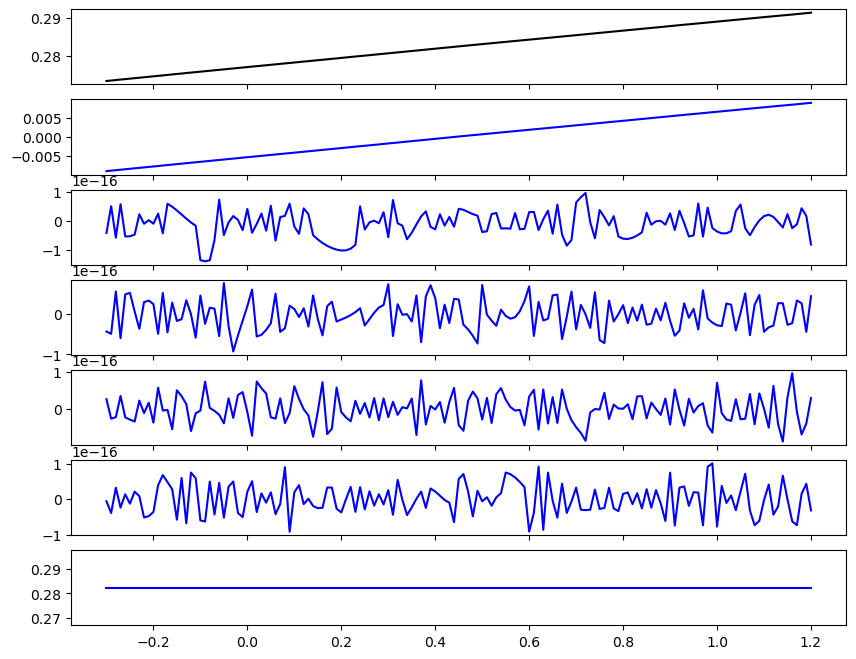

Loading Epochs for S20...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S20_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


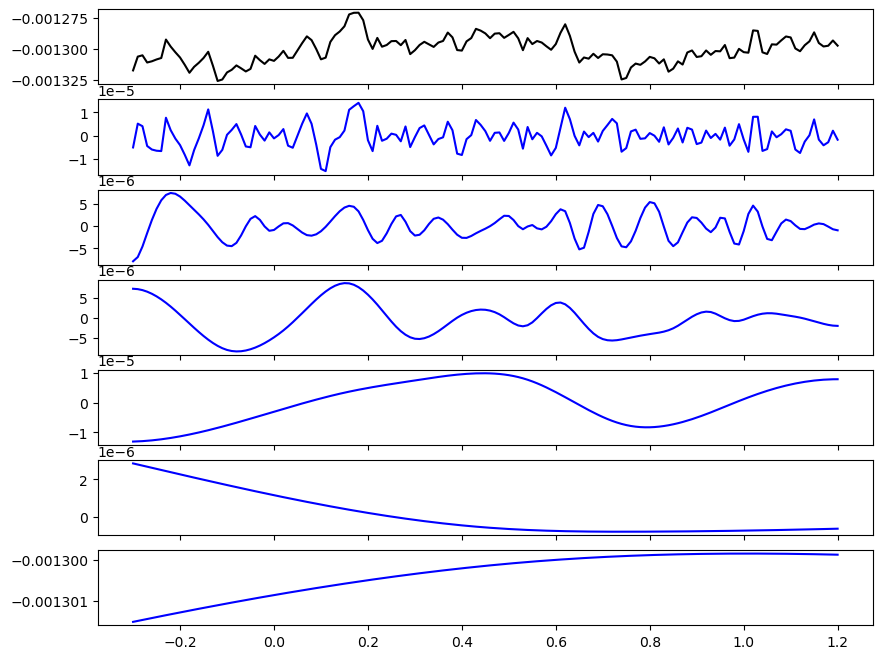

Loading Epochs for S13...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S13_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


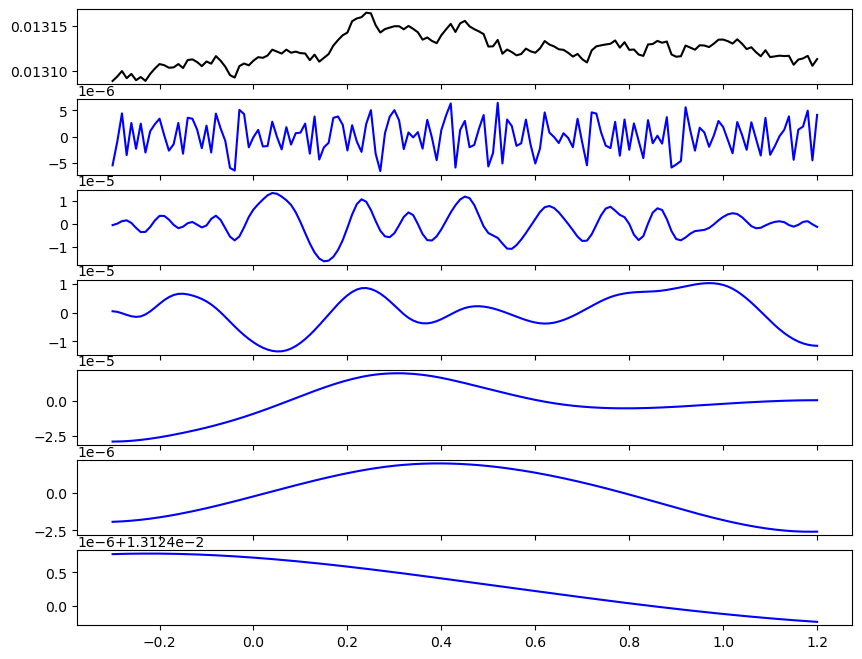

Loading Epochs for S01...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S01_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


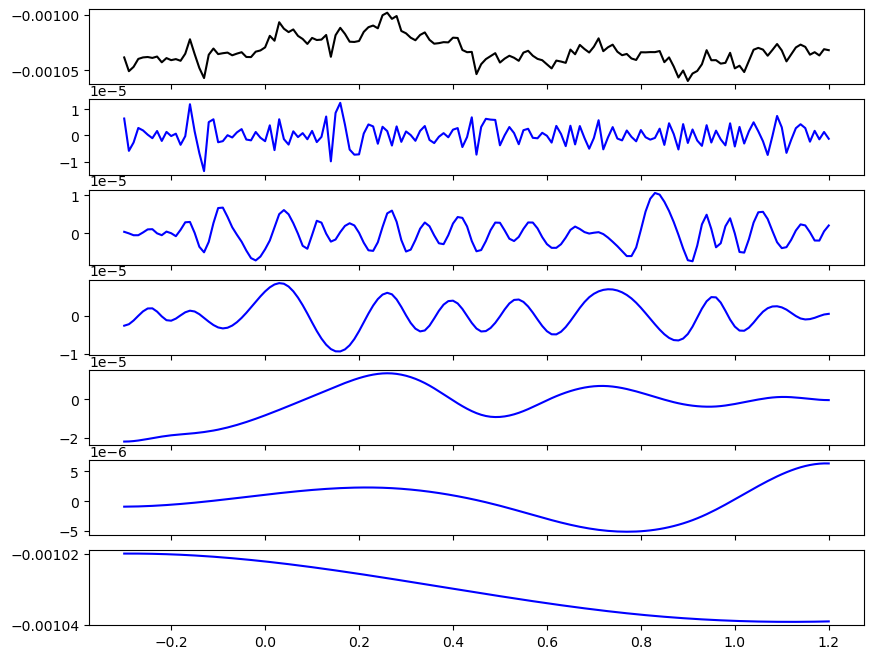

Loading Epochs for S16...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S16_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


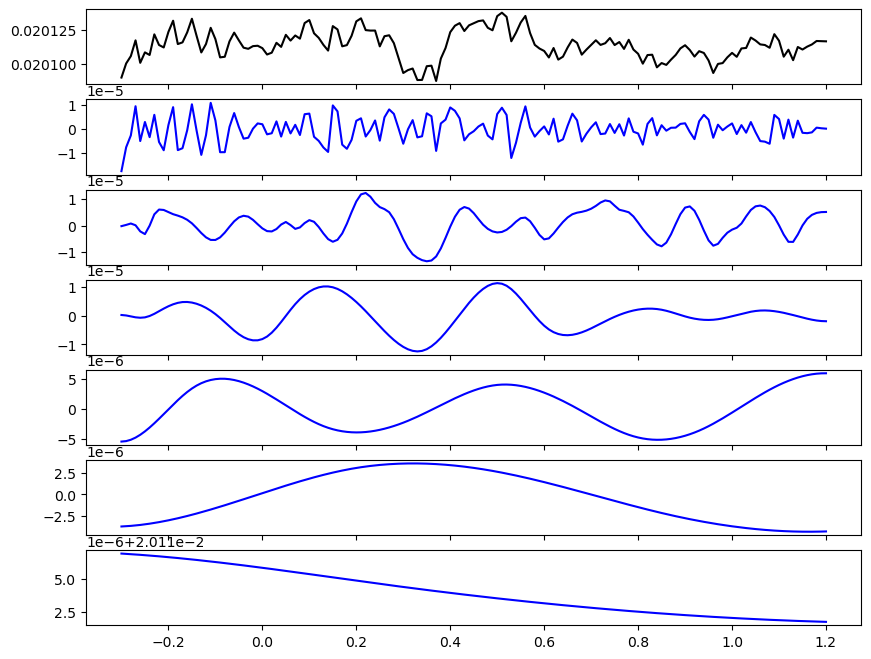

Loading Epochs for S41...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S41_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


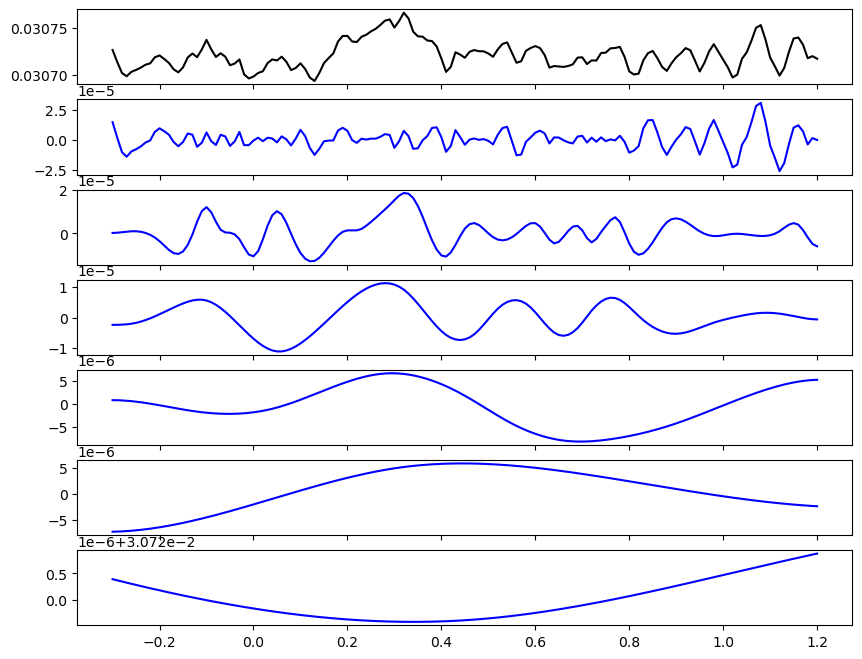

Loading Epochs for S25...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S25_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


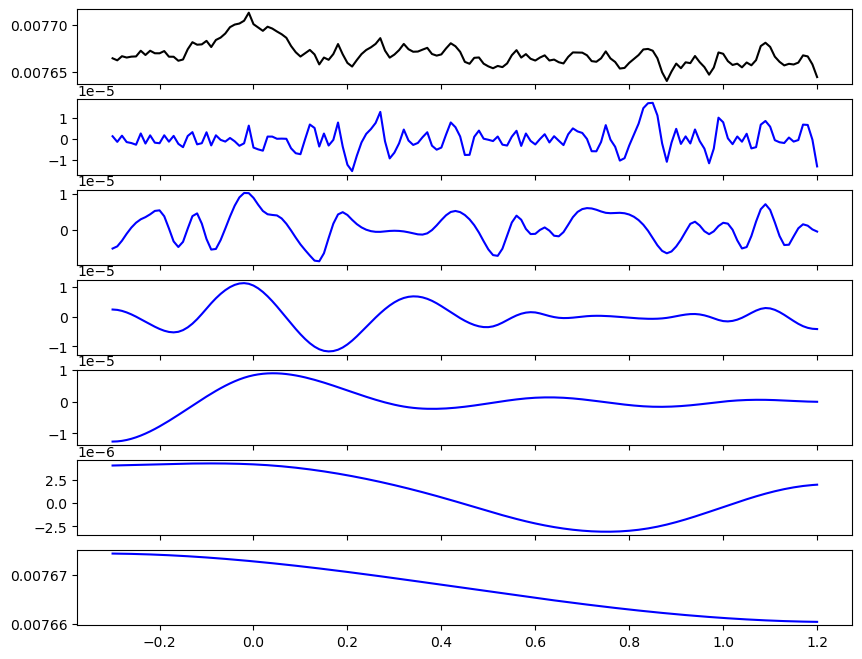

Loading Epochs for S37...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S37_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


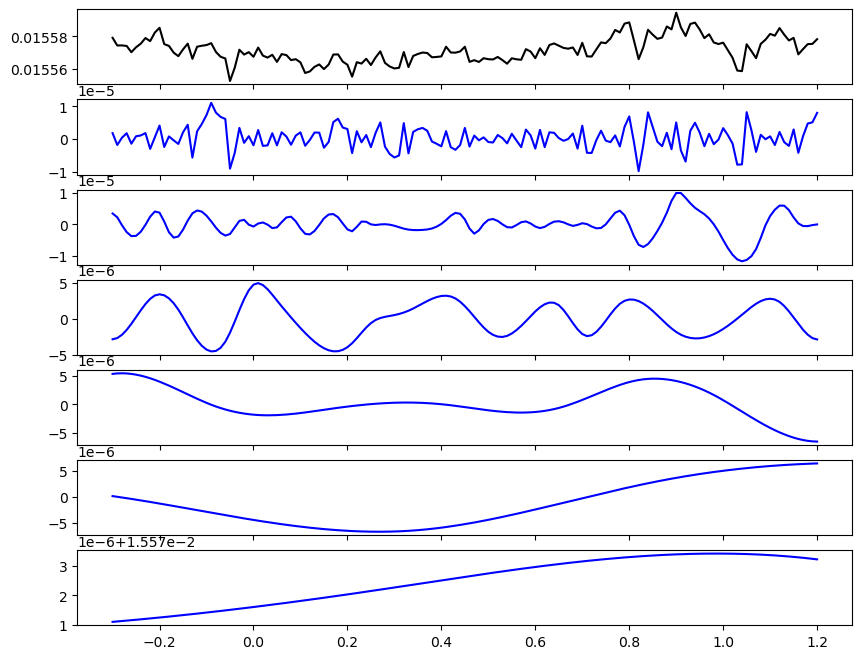

Loading Epochs for S04...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S04_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


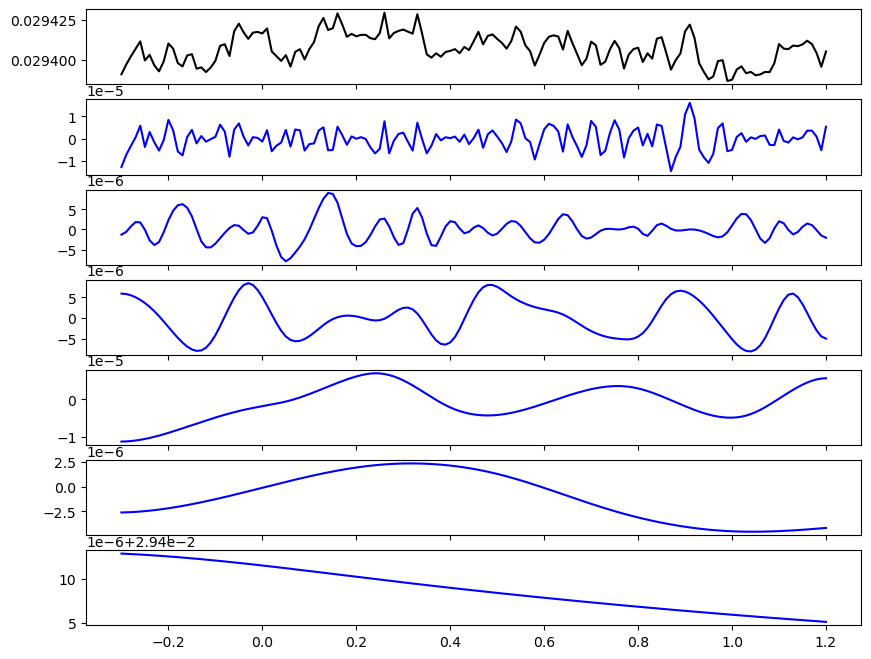

Loading Epochs for S18...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S18_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


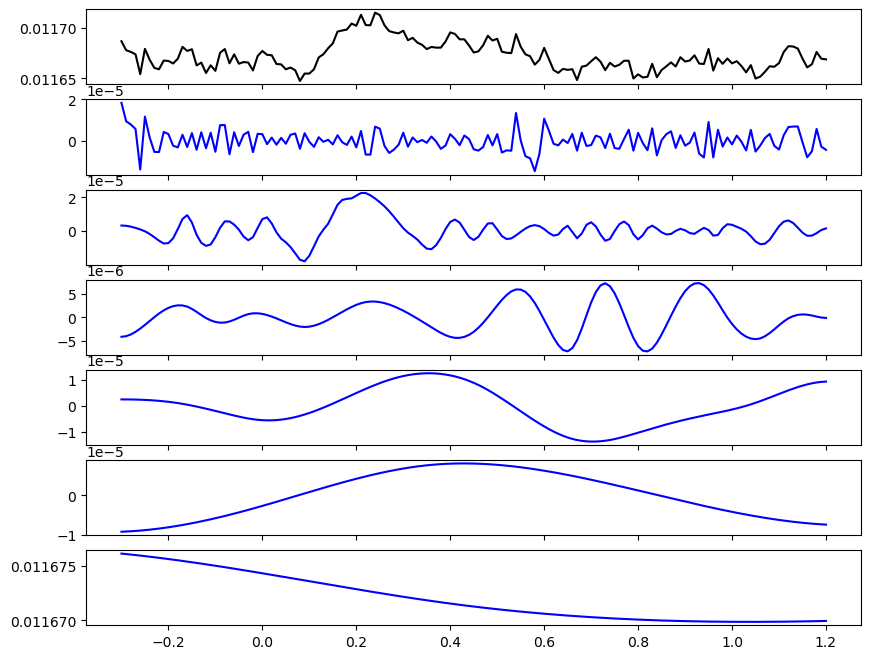

Loading Epochs for S39...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S39_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


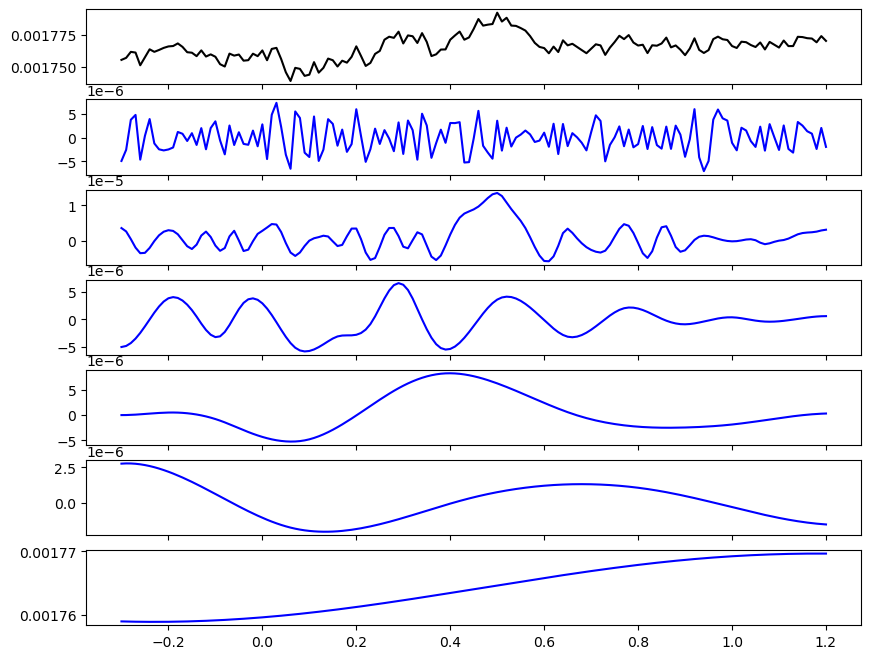

Loading Epochs for S10...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S10_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


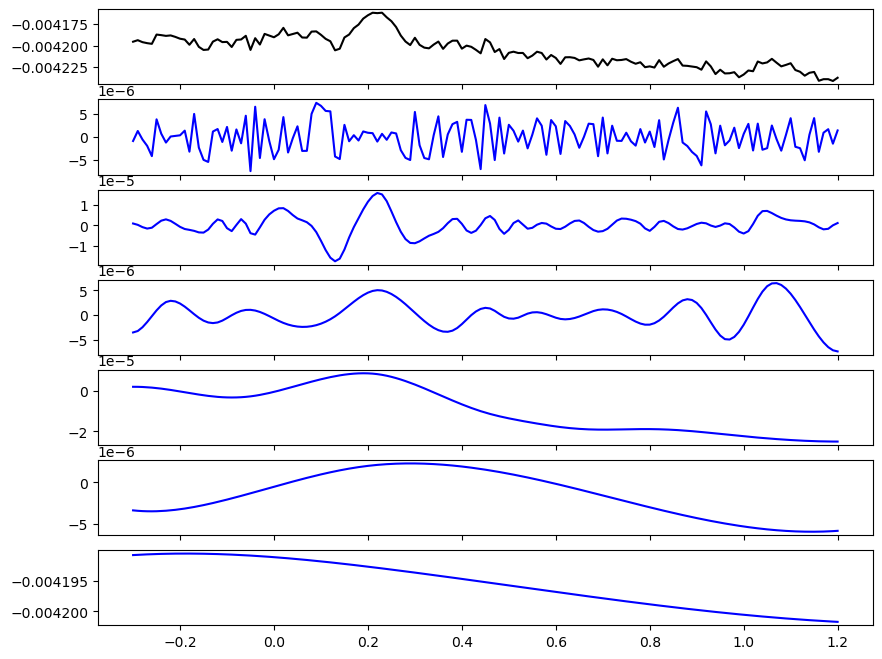

Loading Epochs for S15...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S15_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


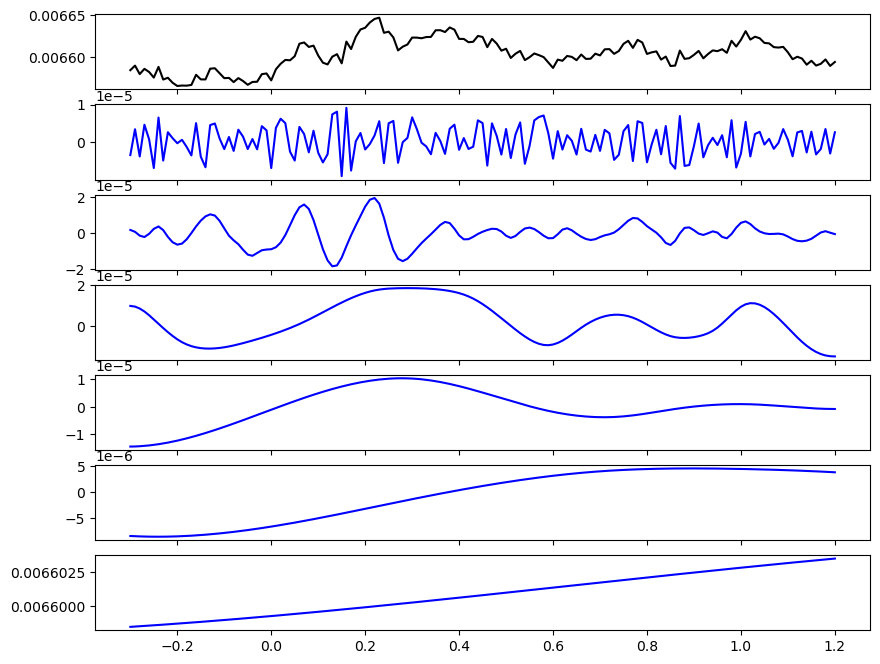

Loading Epochs for S26...
FATAL ERROR during loading: File does not exist: "/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S26_Natives_wOnset_epochs_allTapes_raw.fif"


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/413729148.py:39: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S26_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


FileNotFoundError: File does not exist: "/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S26_Natives_wOnset_epochs_allTapes_raw.fif"

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from pathlib import Path
import emd
from scipy.signal import hilbert
import gc # Garbage Collector


# (This Work!!)Version 2 of .fif. for each layer
# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EPOCH_DIR = wOnset_DIR #DATA_ROOT / 'wOnset_epochs' 
#TARGET_SUBJECT = 'S11' 

for subject in SUBJECTS: #[0:3]:
    TARGET_SUBJECT = subject[0:3]
    # Selection parameters
    TRIAL_INDEX = 0      
    CHANNEL_NAME = '1' # Change this to your actual channel name (e.g., 'Cz')
    TARGET_IMF_INDEX = 1 
    
    # ==========================================
    # 2. LOAD DATA (MNE Epochs)
    # ==========================================
    # Fixed filename to match your exact saved file from the warning
    file_name = f'{TARGET_SUBJECT}_Natives_wOnset_epochs_allTapes_raw.fif'
    file_path = EPOCH_DIR / file_name
    
    print(f"Loading Epochs for {TARGET_SUBJECT}...")
    
    # Initialize signal as None to prevent NameError later
    signal = None
    
    try:
        # Use verbose=False to quiet the naming convention warning
        epochs = mne.read_epochs(file_path, preload=True, verbose=False)
        
        # 1. Pick Channel (Check if channel exists first)
        if CHANNEL_NAME not in epochs.ch_names:
            print(f"Warning: {CHANNEL_NAME} not found. Using first available channel: {epochs.ch_names[0]}")
            CHANNEL_NAME = epochs.ch_names[0]
        
        epochs.pick_channels([CHANNEL_NAME])
        
        # 2. Extract Data 
        # MNE shape: (trials, channels, times)
        data = epochs.get_data() 
        
        # Ensure it's a 1D array for EMD
        signal = data[TRIAL_INDEX, 0, :].flatten()
        
        times = epochs.times
        fs = epochs.info['sfreq']
        
        # Clean up epoch object to save RAM
        del epochs
        gc.collect()
    
        print(f"Data Loaded Successfully: {len(signal)} samples")
    
    except Exception as e:
        print(f"FATAL ERROR during loading: {e}")
        # Stop execution if data didn't load
        raise 
    
    # ==========================================
    # 3. PROCESSING (Only runs if signal exists)
    # ==========================================
    
    if signal is not None:
        # --- A. Layer 1 Decomposition ---
        # Mirror Padding to prevent edge effects
        pad_width = len(signal)
        padded_signal = np.pad(signal, pad_width, mode='reflect')
    
        print("Running Layer 1 Sift...")
        # Using sift (standard) or ensemble_sift (CEEMDAN-like)
        # nprocesses helps speed but can crash some kernels; set to 1 if it crashes
        imfs_layer1_padded = emd.sift.sift(padded_signal, max_imfs=5)
    
        # Un-pad
        imfs_layer1 = imfs_layer1_padded[pad_width : pad_width + len(signal), :]
        n_imfs1 = imfs_layer1.shape[1]
    
        # --- B. Layer 2 Decomposition ---
        target_imf_padded = imfs_layer1_padded[:, TARGET_IMF_INDEX]
    
        # Analytic signal for envelope
        analytic = hilbert(target_imf_padded)
        envelope_padded = np.abs(analytic)
    
        print("Running Layer 2 Sift...")
        imfs_layer2_padded = emd.sift.sift(envelope_padded, max_imfs=4)
    
        # Un-pad
        envelope_real = envelope_padded[pad_width : pad_width + len(signal)]
        imfs_layer2 = imfs_layer2_padded[pad_width : pad_width + len(signal), :]
        n_imfs2 = imfs_layer2.shape[1]
    
        # ==========================================
        # 4. PLOTTING
        # ==========================================
        # (Plotting code remains the same as previous)
        fig1, axes1 = plt.subplots(n_imfs1 + 1, 1, figsize=(10, 8), sharex=True)
        axes1[0].plot(times, signal, 'k')
        for i in range(n_imfs1):
            axes1[i+1].plot(times, imfs_layer1[:, i], 'b')
        plt.savefig(wOnset_DIR / Path('Natives_%s_%s_layer1-IMFs_wOnset.png' %(TARGET_SUBJECT, CHANNEL_NAME)))
        plt.show()
    
    else:
        print("Processing skipped because signal was not defined.")

"""
import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import emd
from scipy.signal import hilbert
"""
# Version 1 of IMFs in each layers (=second EMD)

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TARGET_MODEL = 'Fzero+envelope'
TARGET_SUBJECT = 'S010'  # <--- Change this to look at different subjects

# Which Layer 1 IMF do you want to decompose further?
# 0 = First IMF (Fastest/Highest Freq), 1 = Second IMF, etc.
TARGET_IMF_INDEX = 1 

# ==========================================
# 2. LOAD DATA (Robust Loading)
# ==========================================
file_path = TRF_DIR / TARGET_SUBJECT / f'{TARGET_SUBJECT} {TARGET_MODEL}.pickle'
print(f"Loading {TARGET_SUBJECT}...")

try:
    trf_obj = eelbrain.load.unpickle(file_path)
    
    # Handle h vs h_scaled
    if hasattr(trf_obj, 'h_scaled'):
        data_ndvar = trf_obj.h_scaled
    else:
        data_ndvar = trf_obj.h
        
    # Handle Tuple
    if isinstance(data_ndvar, tuple):
        data_ndvar = data_ndvar[0]

    # Extract Predictor (Strategy: Index)
    # Assumes order is [F0, Envelope] -> Index 1 is Envelope
    # If your model is just 'envelope', it might be Index 0.
    try:
        # Try finding 'envelope' by name
        trf_final = data_ndvar['envelope']
        pred_name = "Envelope"
    except:
        # Fallback to Index 1
        dims = data_ndvar.dimnames
        non_time_dims = [d for d in dims if d != 'time' and d != 'sensor']
        if len(non_time_dims) > 0:
            trf_final = data_ndvar.sub(**{non_time_dims[0]: 1})
            pred_name = "Predictor (Index 1)"
        else:
            trf_final = data_ndvar
            pred_name = "Predictor"

    # Average Sensors
    if 'sensor' in trf_final.dimnames:
        trf_final = trf_final.mean('sensor')
        
    signal = trf_final.x
    times = trf_final.time.times
    fs = 1.0 / trf_final.time.tstep

    if signal.ndim > 1: signal = signal.flatten()
    print(f"Data Loaded: {len(signal)} samples")

except Exception as e:
    print(f"Error loading: {e}")
    exit()

# ==========================================
# 3. PROCESSING (With Mirror Padding)
# ==========================================

# --- A. Layer 1 Decomposition ---
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')

# Run EMD (Sift)
imfs_layer1_padded = emd.sift.sift(padded_signal, max_imfs=5)

# Un-pad Layer 1
# Note: emd output is (Samples, IMFs)
imfs_layer1 = imfs_layer1_padded[pad_width : pad_width + len(signal), :]
n_imfs1 = imfs_layer1.shape[1]

# --- B. Layer 2 Decomposition (Target IMF) ---
# Extract the target IMF (e.g., IMF 0)
target_imf_padded = imfs_layer1_padded[:, TARGET_IMF_INDEX]

# Get Envelope (using Hilbert)
analytic = hilbert(target_imf_padded)
envelope_padded = np.abs(analytic)

# Run EMD on Envelope
imfs_layer2_padded = emd.sift.sift(envelope_padded, max_imfs=4)

# Un-pad Layer 2
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]
imfs_layer2 = imfs_layer2_padded[pad_width : pad_width + len(signal), :]
n_imfs2 = imfs_layer2.shape[1]

# ==========================================
# 4. PLOTTING
# ==========================================

# --- FIGURE 1: LAYER 1 (Carrier) ---
fig1, axes1 = plt.subplots(n_imfs1 + 1, 1, figsize=(10, 8), sharex=True)
fig1.suptitle(f"Layer 1: Carrier Decomposition ({TARGET_SUBJECT})", fontsize=14)

# Plot Original Signal
axes1[0].plot(times, signal, 'k', label='Original TRF')
axes1[0].set_title(f"Original Signal: {pred_name}")
axes1[0].legend(loc='upper right')

# Plot IMFs
for i in range(n_imfs1):
    ax = axes1[i + 1]
    ax.plot(times, imfs_layer1[:, i], 'b')
    ax.set_ylabel(f"IMF {i+1}")
    ax.grid(True, alpha=0.3)

axes1[-1].set_xlabel("Time (s)")
plt.tight_layout()
#plt.savefig(TRF_DIR / 'ESLs_S010_layer1-IMFs_HHSA_TRF.png')
plt.show()


# --- FIGURE 2: LAYER 2 (Amplitude Modulation) ---
fig2, axes2 = plt.subplots(n_imfs2 + 1, 1, figsize=(10, 8), sharex=True)
fig2.suptitle(f"Layer 2: AM Decomposition of Carrier IMF {TARGET_IMF_INDEX+1}", fontsize=14)

# Plot Envelope
axes2[0].plot(times, envelope_real, 'r', label=f'Envelope of IMF {TARGET_IMF_INDEX+1}')
axes2[0].set_title("Amplitude Envelope (Input to Layer 2)")
axes2[0].legend(loc='upper right')

# Plot AM IMFs
for i in range(n_imfs2):
    ax = axes2[i + 1]
    ax.plot(times, imfs_layer2[:, i], 'g')
    ax.set_ylabel(f"AM IMF {i+1}")
    ax.grid(True, alpha=0.3)

axes2[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.savefig(TRF_DIR / 'ESLs_S010_layer2-IMF2_HHSA_TRF.png')
plt.show()